In [139]:
# 由于要实现的模型涉及到比较复杂的数据处理和分析，我们将从简单的数据探索开始，
# 然后尝试定义并计算动量指标，最后进行简单的可视化展示。
# 本例将重点放在如何根据比赛分数计算动量，并不会构建一个完整的状态空间模型。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


In [140]:
# 改进势头计算函数以包括赢得的局数和盘数，以及更精确的发球优势计算
def calculate_momentum_improved(df, index, window_size=5):
    start_index = max(index - window_size, 0)
    # end_index = min(index + window_size + 1, len(df))
    end_index = index + 1
    time_window_df = df.iloc[start_index:end_index]

    # 初始化势头值
    p1_momentum = 0
    p2_momentum = 0

    # 赢得的局数和盘数
    '''
    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]
    print(p2_sets_won)
    '''
    
    p1_sets_won = time_window_df['set_victor'].apply(lambda x: x == 1).sum()
    p2_sets_won = time_window_df['set_victor'].apply(lambda x: x == 2).sum()
    p1_games_won = time_window_df['game_victor'].apply(lambda x: x == 1).sum()
    p2_games_won = time_window_df['game_victor'].apply(lambda x: x == 2).sum()

    # 发球优势
    # 假设发球方在每个得分上的额外权重为0.1
    serve_advantage_weight = 0.1
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # 其他因素（得分优势、破发点、非受迫性失误、制胜分）
    p1_points_advantage = time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()
    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()
    p1_winners = time_window_df['p1_winner'].sum()
    p2_winners = time_window_df['p2_winner'].sum()

    # 合并计算势头
    p1_momentum = p1_points_advantage + p1_serve_advantage + p1_break_points_won * 0.5 + p1_unforced_errors * 0.3 + p1_winners + p1_sets_won + p1_games_won
    p2_momentum = p2_points_advantage + p2_serve_advantage + p2_break_points_won * 0.5 + p2_unforced_errors * 0.3+ p2_winners + p2_sets_won + p2_games_won

    return p1_momentum, p2_momentum

import ruptures as rpt
def cumsum_detection(series):
    """
    CUMSUM检测算法实现，用于检测序列中的转折点。
    :param series: 一维数据序列 (Pandas Series)
    :return: 转折点的索引列表
    """
      # 将Pandas Series转换为NumPy数组
    data = series.values.reshape(-1, 1)

    # 使用Pelt方法进行累积和检测
    model = rpt.Pelt(model="rbf").fit(data)
    result = model.predict(pen=0)  # 适当调整pen的值

    # 获取转折点的索引
    turning_points = result[:-1]
    
    return turning_points

# 定义一个函数，输入是p1_turning_points与p2_turning_points，输出是一列数据，对应data的每一行数据
def mark_turning_points(data_length, p1_turning_points, p2_turning_points):
    # 初始化标记列为0
    turning_points_mark = [0] * data_length
    
    # 标记转折点为1
    for index in p1_turning_points:
        if index < data_length:
            turning_points_mark[index] = 1
    for index in p2_turning_points:
        if index < data_length:
            turning_points_mark[index] = 1
    
    return turning_points_mark

from scipy.stats import norm

def runs_test(sequence):
    """
    游程检验，判断序列随机性。
    :param sequence: 输入的序列 (list or np.array)
    :return: Z统计量和p值
    """
    # 将序列分为两类
    median_value = np.median(sequence)
    binary_sequence = [1 if x > median_value else 0 for x in sequence]
    
    # 计算游程数量
    runs = 1  # 至少有一个游程
    for i in range(1, len(binary_sequence)):
        if binary_sequence[i] != binary_sequence[i-1]:
            runs += 1
    
    # 计算期望的游程数量和标准差
    n1 = binary_sequence.count(1)
    n2 = binary_sequence.count(0)
    expected_runs = 2 * n1 * n2 / (n1 + n2) + 1
    variance = (expected_runs - 1) * (expected_runs - 2) / (n1 + n2 - 1)
    
    # 计算Z统计量
    Z = (runs - expected_runs) / np.sqrt(variance)
    
    # 计算p值
    p_value = 2 * (1 - norm.cdf(abs(Z)))  # 双尾检验
    
    return Z, p_value
def mark_indices_in_list(length, indices):
    """
    根据指定的索引列表，在长度为length的列表中标记索引位置。
    
    :param length: 列表的长度
    :param indices: 需要标记为1的索引值列表
    :return: 标记后的列表，其中指定索引位置为1，其他位置为0
    """
    # 初始化列表，长度为length，所有值为0
    marked_list = [0] * length
    
    # 在指定索引位置标记为1
    for index in indices:
        if index < length:  # 确保索引在列表长度范围内
            marked_list[index] = 1
            
    return marked_list


def getva(x):
    if x<0.05:
        return 1
    else:
        return 0

In [141]:
# 读取数据
df = pd.read_csv('G:\\operating_platform\\MCM\\MCM_problem\\Wimbledon_featured_matches.csv')

In [142]:


# 选择一场特定的比赛进行分析，根据题目描述选择2023年温布尔登决赛
# 假设决赛的match_id为"2023-wimbledon-1701"

dddd=pd.DataFrame()
for match_id in df['match_id'].unique():
    # match_id = "2023-wimbledon-1701"
    match_data = df[df['match_id'] == match_id].copy()
    match_data.reset_index(inplace=True,drop=True)
    # 对数据集中的每一行应用计算势头的函数
    momentum_values = [calculate_momentum_improved(match_data, index) for index in range(len(match_data))]
    p1_momentum=[]
    p2_momentum=[]
    for i in momentum_values:
        p1_momentum.append(i[0])
        p2_momentum.append(i[1])
    # 将计算得到的势头值分配回原始数据集
    match_data['p1_momentum']=pd.DataFrame(p1_momentum)
    match_data['p2_momentum']=pd.DataFrame(p2_momentum)
    
#     p1_turning_points = cumsum_detection(match_data['p1_momentum'])
#     p2_turning_points = cumsum_detection(match_data['p2_momentum'])
#     list_length=len(match_data)
#     p1_turning_points = mark_indices_in_list(list_length, p1_turning_points)
#     p2_turning_points = mark_indices_in_list(list_length, p2_turning_points)
#     match_data['p1_turning_points']=pd.DataFrame(p1_turning_points)
#     match_data['p2_turning_points']=pd.DataFrame(p2_turning_points)
    dddd=pd.concat([dddd,match_data],axis=0)

In [143]:
dddd=pd.DataFrame(dddd)

In [144]:
temp=dddd[(dddd['player1']=='Carlos Alcaraz')&(dddd['player2']=='Nicolas Jarry')]
temp

match_id         player1        player2 elapsed_time  set_no  \
0    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   
..                   ...             ...            ...          ...     ...   
295  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:53:25       4   
296  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:54:01       4   
297  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:55:02       4   
298  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:55:34       4   
299  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:56:11       4   

     game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_break_pt_missed  \
0          1         1        0        0         0  ...                   0   
1          1         2        0        0         0  ...                   0   
2          1         3        0        0         0  ...                   0   
3          1         4        0        0         0  ...                   0   
4          1         5        0        0         0  ...                   0   
..       ...       ...      ...      ...       ...  ...                 ...   
295       12       296        2        1         6  ...                   0   
296       12       297        2        1         6  ...                   0   
297       12       298        2        1         6  ...                   1   
298       12       299        2        1         6  ...                   0   
299       12       300        2        1         6  ...                   0   

    p1_distance_run p2_distance_run  rally_count  speed_mph  serve_width  \
0             6.000           7.840            2       95.0           BC   
1             5.253           7.094            1      118.0            B   
2            13.800          19.808            4      120.0            B   
3            51.108          75.631           13      130.0           BW   
4             0.649           0.813            1      112.0            W   
..              ...             ...          ...        ...          ...   
295          10.044           9.281            2      130.0           BW   
296          52.318          58.723           14      113.0           BW   
297           2.056           1.509            1      129.0            B   
298          12.292          32.582            1      128.0            C   
299           3.767           6.518            1      116.0           BW   

     serve_depth  return_depth  p1_momentum  p2_momentum  
0           NCTL            ND         -1.3          1.0  
1            CTL            ND         -0.2          0.0  
2           NCTL             D         -1.5          1.0  
3            CTL             D          0.6          0.0  
4           NCTL           NaN          2.7         -1.0  
..           ...           ...          ...          ...  
295         NCTL            ND          5.4         -2.3  
296         NCTL            ND          3.4          1.0  
297         NCTL            ND          1.0          1.0  
298         NCTL            ND          3.4         -1.0  
299         NCTL            ND          5.4         -1.0  

[300 rows x 48 columns]

In [145]:
temp.isnull().sum()

match_id               0
player1                0
player2                0
elapsed_time           0
set_no                 0
game_no                0
point_no               0
p1_sets                0
p2_sets                0
p1_games               0
p2_games               0
p1_score               0
p2_score               0
server                 0
serve_no               0
point_victor           0
p1_points_won          0
p2_points_won          0
game_victor            0
set_victor             0
p1_ace                 0
p2_ace                 0
p1_winner              0
p2_winner              0
winner_shot_type       0
p1_double_fault        0
p2_double_fault        0
p1_unf_err             0
p2_unf_err             0
p1_net_pt              0
p2_net_pt              0
p1_net_pt_won          0
p2_net_pt_won          0
p1_break_pt            0
p2_break_pt            0
p1_break_pt_won        0
p2_break_pt_won        0
p1_break_pt_missed     0
p2_break_pt_missed     0
p1_distance_run        0


In [146]:
del temp['return_depth']

In [147]:
temp.reset_index(inplace=True,drop=True)

In [148]:
temp.fillna(method='backfill',inplace=True)
temp.isnull().sum()

match_id              0
player1               0
player2               0
elapsed_time          0
set_no                0
game_no               0
point_no              0
p1_sets               0
p2_sets               0
p1_games              0
p2_games              0
p1_score              0
p2_score              0
server                0
serve_no              0
point_victor          0
p1_points_won         0
p2_points_won         0
game_victor           0
set_victor            0
p1_ace                0
p2_ace                0
p1_winner             0
p2_winner             0
winner_shot_type      0
p1_double_fault       0
p2_double_fault       0
p1_unf_err            0
p2_unf_err            0
p1_net_pt             0
p2_net_pt             0
p1_net_pt_won         0
p2_net_pt_won         0
p1_break_pt           0
p2_break_pt           0
p1_break_pt_won       0
p2_break_pt_won       0
p1_break_pt_missed    0
p2_break_pt_missed    0
p1_distance_run       0
p2_distance_run       0
rally_count     

In [149]:
temp.dtypes


match_id               object
player1                object
player2                object
elapsed_time           object
set_no                  int64
game_no                 int64
point_no                int64
p1_sets                 int64
p2_sets                 int64
p1_games                int64
p2_games                int64
p1_score               object
p2_score               object
server                  int64
serve_no                int64
point_victor            int64
p1_points_won           int64
p2_points_won           int64
game_victor             int64
set_victor              int64
p1_ace                  int64
p2_ace                  int64
p1_winner               int64
p2_winner               int64
winner_shot_type       object
p1_double_fault         int64
p2_double_fault         int64
p1_unf_err              int64
p2_unf_err              int64
p1_net_pt               int64
p2_net_pt               int64
p1_net_pt_won           int64
p2_net_pt_won           int64
p1_break_p

In [150]:
temp['p1_score'].unique()

array(['0', '15', '30', '40', 'AD', '1', '2', '3', '4', '5', '6'],
      dtype=object)

这个术语是用于描述网球比赛中的得分情况的。具体解释如下：

- "p1_score" 表示球员1的得分，也就是一场比赛中球员1的当前得分情况。
- "0 (love)" 表示球员1的得分为0分，通常在比赛中称为"love"。
- "15" 表示球员1的得分为15分。
- "30" 表示球员1的得分为30分。
- "40" 表示球员1的得分为40分。
- "AD (advantage)" 表示球员1处于优势地位，通常用于描述在比赛中的一种特殊情况。如果比分达到40平，而球员1再次得分，他们将处于"优势"地位，需要再次得分才能赢得比赛。

这些术语通常用于网球比赛中，以记录和表示比赛的得分情况。在网球比赛中，通常需要达到40分才能赢得一局，但在一些情况下，需要赢得两个连续的得分才能获胜，这时会出现"AD"表示优势。

In [151]:
temp['winner_shot_type'].unique()

array(['0', 'F', 'B'], dtype=object)

In [152]:
temp['serve_width'].unique()

array(['BC', 'B', 'BW', 'W', 'C'], dtype=object)

In [153]:
temp['serve_depth'].unique()

array(['NCTL', 'CTL'], dtype=object)

In [154]:
temp1=pd.get_dummies(temp[['p1_score','p2_score','winner_shot_type','serve_width','serve_depth']])


temp2=temp[['set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games','server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'p1_double_fault',
       'p2_double_fault', 'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt',
       'p1_net_pt_won', 'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt',
       'p1_break_pt_won', 'p2_break_pt_won', 'p1_break_pt_missed',
       'p2_break_pt_missed', 'p1_distance_run', 'p2_distance_run',
       'rally_count', 'speed_mph', 'p1_momentum', 'p2_momentum']]


In [155]:
data=pd.concat([temp1,temp2],axis=1)
data

p1_score_0  p1_score_1  p1_score_15  p1_score_2  p1_score_3  p1_score_30  \
0          True       False        False       False       False        False   
1          True       False        False       False       False        False   
2         False       False         True       False       False        False   
3         False       False         True       False       False        False   
4         False       False        False       False       False         True   
..          ...         ...          ...         ...         ...          ...   
295       False       False        False       False       False         True   
296       False       False        False       False       False         True   
297       False       False        False       False       False         True   
298       False       False        False       False       False        False   
299       False       False        False       False       False        False   

     p1_score_4  p1_score_40  p1_score_5  p1_score_6  ...  p1_break_pt_won  \
0         False        False       False       False  ...                0   
1         False        False       False       False  ...                0   
2         False        False       False       False  ...                0   
3         False        False       False       False  ...                0   
4         False        False       False       False  ...                0   
..          ...          ...         ...         ...  ...              ...   
295       False        False       False       False  ...                0   
296       False        False       False       False  ...                0   
297       False        False       False       False  ...                0   
298       False         True       False       False  ...                0   
299       False        False       False       False  ...                0   

     p2_break_pt_won  p1_break_pt_missed  p2_break_pt_missed  p1_distance_run  \
0                  0                   0                   0            6.000   
1                  0                   0                   0            5.253   
2                  0                   0                   0           13.800   
3                  0                   0                   0           51.108   
4                  0                   0                   0            0.649   
..               ...                 ...                 ...              ...   
295                0                   0                   0           10.044   
296                0                   0                   0           52.318   
297                0                   0                   1            2.056   
298                0                   0                   0           12.292   
299                0                   0                   0            3.767   

     p2_distance_run  rally_count  speed_mph  p1_momentum  p2_momentum  
0              7.840            2       95.0         -1.3          1.0  
1              7.094            1      118.0         -0.2          0.0  
2             19.808            4      120.0         -1.5          1.0  
3             75.631           13      130.0          0.6          0.0  
4              0.813            1      112.0          2.7         -1.0  
..               ...          ...        ...          ...          ...  
295            9.281            2      130.0          5.4         -2.3  
296           58.723           14      113.0          3.4          1.0  
297            1.509            1      129.0          1.0          1.0  
298           32.582            1      128.0          3.4         -1.0  
299            6.518            1      116.0          5.4         -1.0  

[300 rows x 71 columns]

In [156]:
data.columns

Index(['p1_score_0', 'p1_score_1', 'p1_score_15', 'p1_score_2', 'p1_score_3',
       'p1_score_30', 'p1_score_4', 'p1_score_40', 'p1_score_5', 'p1_score_6',
       'p1_score_AD', 'p2_score_0', 'p2_score_1', 'p2_score_15', 'p2_score_2',
       'p2_score_3', 'p2_score_30', 'p2_score_4', 'p2_score_40', 'p2_score_5',
       'p2_score_6', 'p2_score_7', 'p2_score_AD', 'winner_shot_type_0',
       'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_B',
       'serve_width_BC', 'serve_width_BW', 'serve_width_C', 'serve_width_W',
       'serve_depth_CTL', 'serve_depth_NCTL', 'set_no', 'game_no', 'point_no',
       'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt'

In [157]:
data['p1_momentum_diff1']=data['p1_momentum'].diff(1)

In [158]:
data=data.dropna()

In [159]:
data.reset_index(inplace=True,drop=True)

In [160]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc,precision_score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
# 分离X和Y
X = data[['p1_score_0', 'p1_score_1', 'p1_score_15', 'p1_score_2', 'p1_score_3',
       'p1_score_30', 'p1_score_4', 'p1_score_40', 'p1_score_5', 'p1_score_6',
       'p1_score_AD', 'p2_score_0', 'p2_score_1', 'p2_score_15', 'p2_score_2',
       'p2_score_3', 'p2_score_30', 'p2_score_4', 'p2_score_40', 'p2_score_5',
       'p2_score_6', 'p2_score_7', 'p2_score_AD', 'winner_shot_type_0',
       'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_B',
       'serve_width_BC', 'serve_width_BW', 'serve_width_C', 'serve_width_W',
       'serve_depth_CTL', 'serve_depth_NCTL', 'set_no', 'game_no', 'point_no',
       'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won', 'p2_break_pt_won',
       'p1_break_pt_missed', 'p2_break_pt_missed', 'p1_distance_run',
       'p2_distance_run', 'rally_count', 'speed_mph']]



Y = data['p1_momentum_diff1']


In [161]:
# 此处所引入的包大部分为下文机器学习算法
import pandas as pd
from numpy import *
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import xgboost as xgb

from sklearn.metrics import accuracy_score,recall_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor


import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))


In [162]:
tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.3,random_state=5)

神经网络:
训练集平均绝对百分比误差:8.643
测试集平均绝对百分比误差:11.189
平均绝对误差: 1.6935848036944432
r2_score -0.22915234813090057


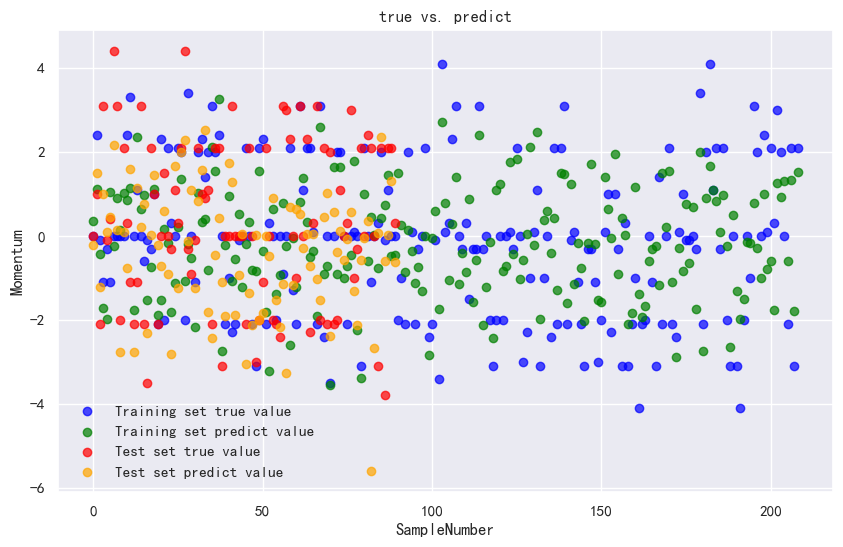


线性回归:
训练集平均绝对百分比误差:2.327
测试集平均绝对百分比误差:2.726
平均绝对误差: 1.3665184868706595
r2_score 0.32459231512037434


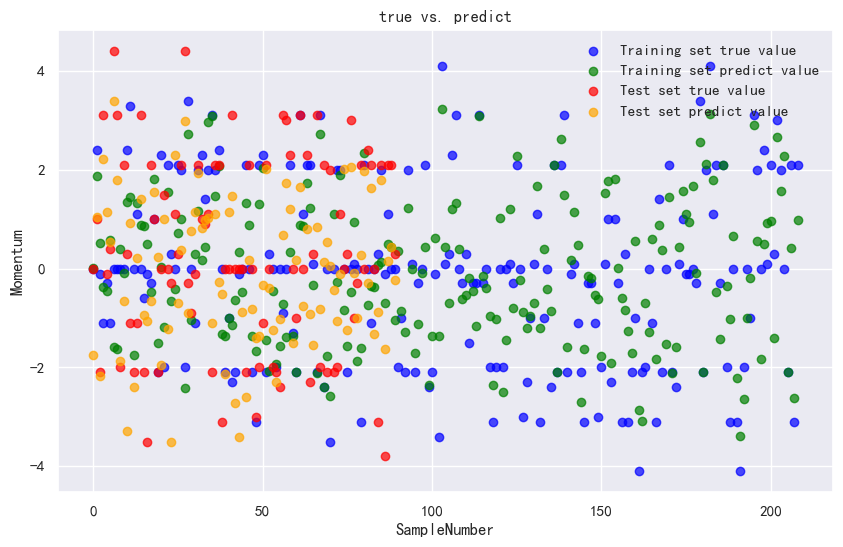


决策树回归:
训练集平均绝对百分比误差:nan
测试集平均绝对百分比误差:nan
平均绝对误差: 1.6755555555555557
r2_score -0.11954778581137449


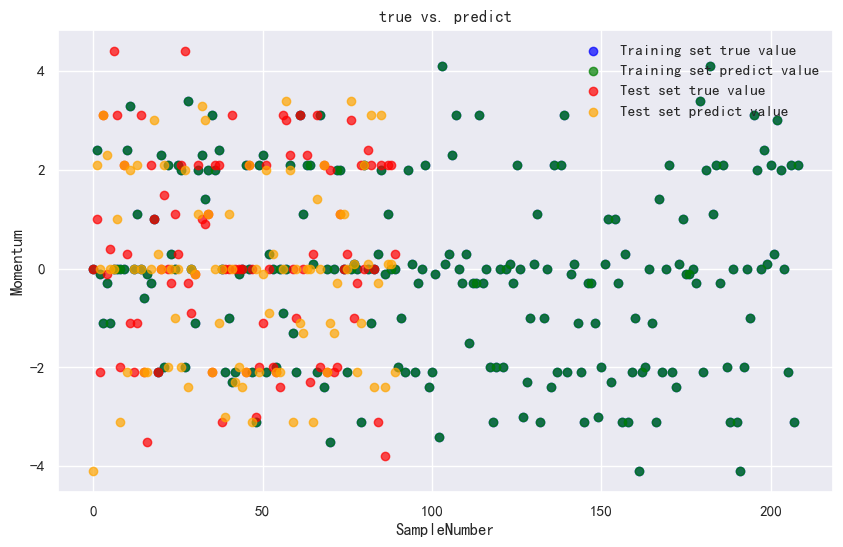


随机森林回归:
训练集平均绝对百分比误差:0.850
测试集平均绝对百分比误差:2.164
平均绝对误差: 1.2451444444444444
r2_score 0.46431803598221966


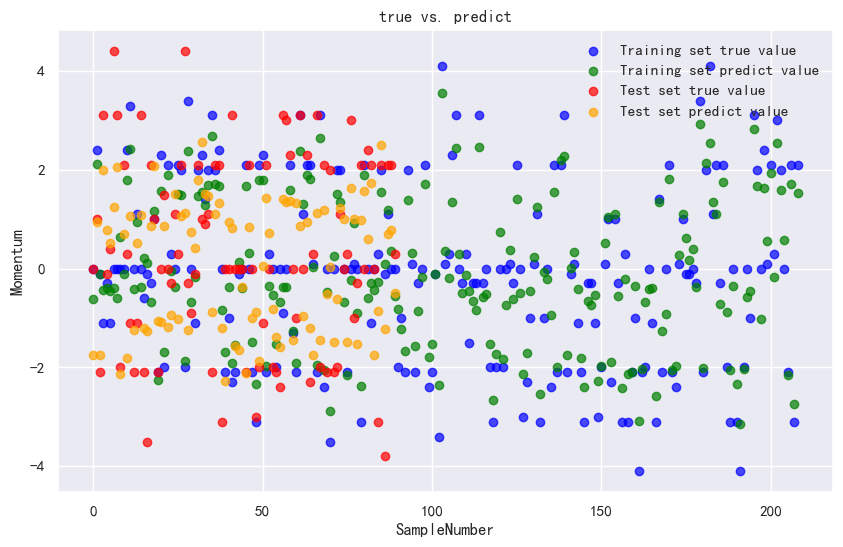


Adaboost回归:
训练集平均绝对百分比误差:2.085
测试集平均绝对百分比误差:5.261
平均绝对误差: 1.2586281776382602
r2_score 0.4721306552599094


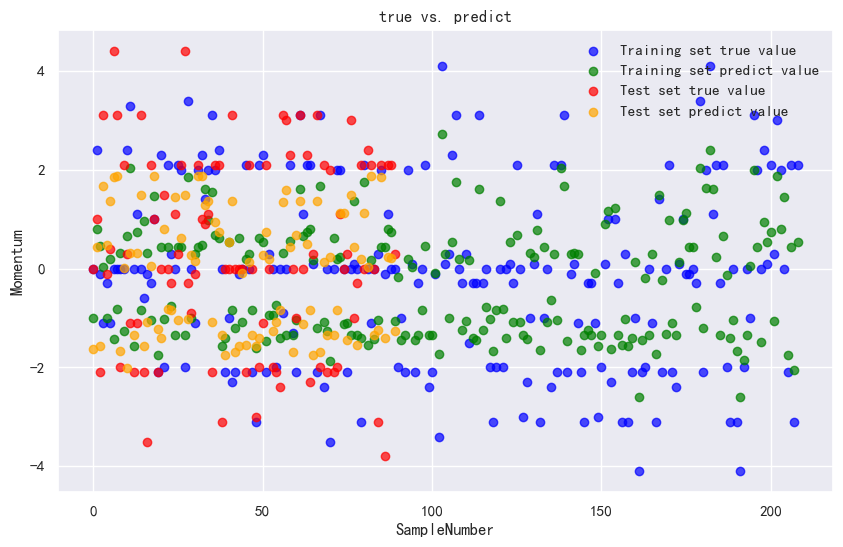


GBDT回归:
训练集平均绝对百分比误差:1.769
测试集平均绝对百分比误差:3.011
平均绝对误差: 0.680668864002709
r2_score 0.8284443340530762


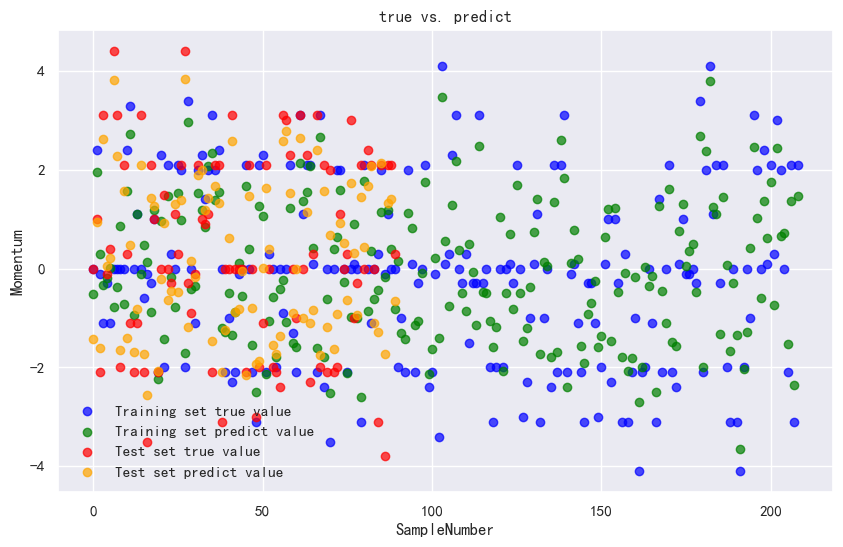


xgboost回归:
训练集平均绝对百分比误差:0.187
测试集平均绝对百分比误差:0.169
平均绝对误差: 0.0025077278222307023
r2_score 0.9999957821327825


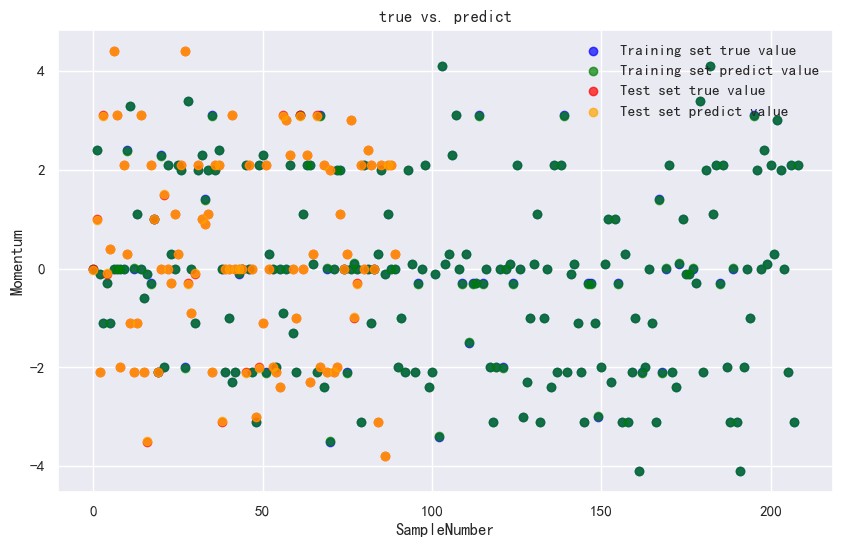

In [163]:




from sklearn.preprocessing import StandardScaler

model=MLPRegressor(hidden_layer_sizes=10,max_iter=1000).fit(tr_x,tr_y)
y_pred=model.predict(te_x)

print("神经网络:")
print("训练集平均绝对百分比误差:{:.3f}".format(mape(model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))


# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()



print("\n线性回归:")
logreg = LinearRegression()
logreg.fit(tr_x, tr_y)
y_pred = logreg.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = logreg.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = logreg.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()

      
print("\n决策树回归:")
tree=DecisionTreeRegressor(max_depth=50,random_state=0)
tree.fit(tr_x,tr_y)
y_pred = tree.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = tree.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = tree.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()
      
      
print("\n随机森林回归:")
rf=RandomForestRegressor()
rf.fit(tr_x,tr_y)

y_pred = rf.predict(te_x)

print("训练集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = rf.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = rf.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()
      

# print("\nLGBM回归:")
# lgb_model=lgb.LGBMRegressor()
# lgb_model.fit(tr_x,tr_y)
# y_pred = lgb_model.predict(te_x)
# print("训练集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(tr_x),tr_y)))
# print("测试集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(te_x),te_y)))
# print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
# print("r2_score",r2_score(te_y,y_pred))

# # 真实值与拟合值的对比图
# plt.figure(figsize=(10, 6))

# # 训练集
# tr_y_pred = lgb_model.predict(tr_x)
# plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
# plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# # 测试集
# te_y_pred = lgb_model.predict(te_x)
# plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
# plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# # 为图添加标题和图例
# plt.title('真实值 vs. 预测值')
# plt.xlabel('样本序号')
# plt.ylabel('综合得分')
# plt.legend()
# # 显示图形
# plt.show()

print("\nAdaboost回归:")
# 构建Adaboost回归模型
ada_model = AdaBoostRegressor(n_estimators=100)
ada_model.fit(tr_x,tr_y)
y_pred = ada_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(ada_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(ada_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = ada_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = ada_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()

print("\nGBDT回归:")
# 构建GBDT回归模型
gbdt_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbdt_model.fit(X, Y)
y_pred = gbdt_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(gbdt_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(gbdt_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = gbdt_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = gbdt_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()

print("\nxgboost回归:")
# 构建xgboost回归模型
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, Y)

y_pred = xgb_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = xgb_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = xgb_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()





支持向量机回归:
训练集平均绝对百分比误差:41.114
测试集平均绝对百分比误差:29.498
平均绝对误差: 0.9883221908543595
r2_score: 0.5723378065642528


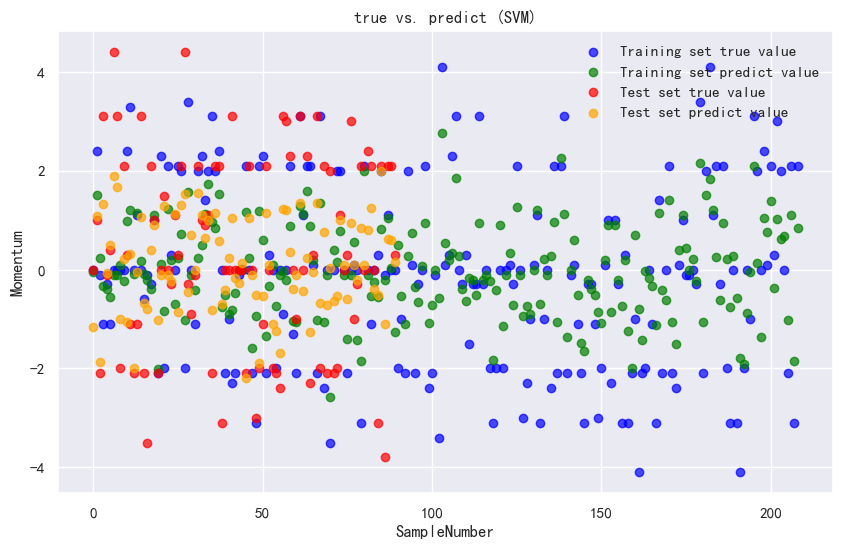

In [164]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# 构建支持向量机回归模型
svm_model = SVR()

# 标准化输入数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
tr_x_scaled = scaler.transform(tr_x)
te_x_scaled = scaler.transform(te_x)

svm_model.fit(X_scaled, Y)

# 对训练集和测试集进行预测
tr_y_pred_svm = svm_model.predict(tr_x_scaled)
te_y_pred_svm = svm_model.predict(te_x_scaled)

# 输出评估指标
print("\n支持向量机回归:")
print("训练集平均绝对百分比误差:{:.3f}".format(mape(tr_y_pred_svm, tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(te_y_pred_svm, te_y)))
print("平均绝对误差:", mean_absolute_error(te_y, te_y_pred_svm))
print("r2_score:", r2_score(te_y, te_y_pred_svm))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred_svm, color='green', label='Training set predict value', alpha=0.7)

# 测试集
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred_svm, color='orange', label='Test set predict value', alpha=0.7)

# 为图添加标题和图例
plt.title('true vs. predict (SVM)')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()

Epoch 1/50
7/7 [==============================] - 1s 3ms/step - loss: 3.4688
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 3.3151
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 3.2351
Epoch 4/50
7/7 [==============================] - 0s 4ms/step - loss: 3.1358
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 3.0277
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 2.8981
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 2.7879
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 2.6785
Epoch 9/50
7/7 [==============================] - 0s 3ms/step - loss: 2.5736
Epoch 10/50
7/7 [==============================] - 0s 3ms/step - loss: 2.4453
Epoch 11/50
7/7 [==============================] - 0s 3ms/step - loss: 2.4295
Epoch 12/50
7/7 [==============================] - 0s 3ms/step - loss: 2.1705
Epoch 13/50
7/7 [==============================] - 0s 3ms/step - loss: 2.

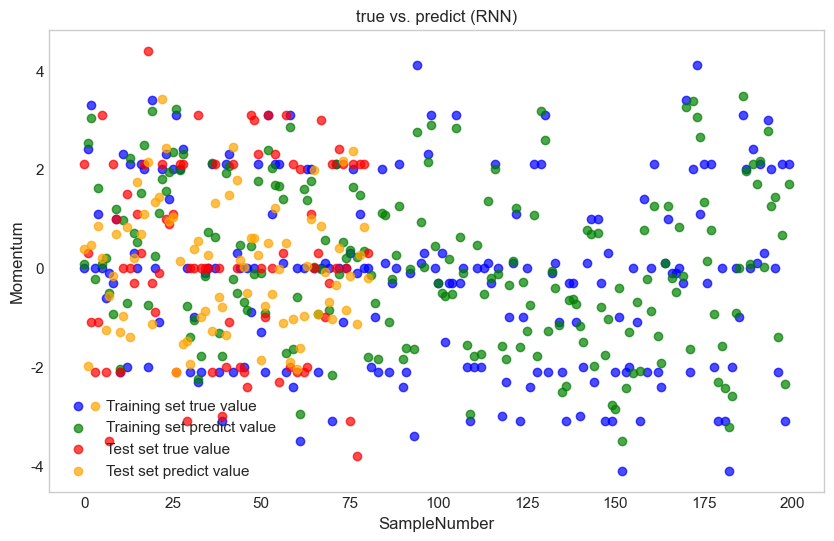

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 特征缩放
scaler = MinMaxScaler()
tr_x_scaled = scaler.fit_transform(tr_x)
te_x_scaled = scaler.transform(te_x)

# 将数据转化为RNN模型所需的格式
def create_dataset(X, Y, time_steps=1):
    X_dataset, Y_dataset = [], []
    for i in range(len(X) - time_steps + 1):
        x = X[i:(i + time_steps), :]
        y = Y[i + time_steps - 1]
        X_dataset.append(x)
        Y_dataset.append(y)
    return np.array(X_dataset), np.array(Y_dataset)

time_steps = 10  # 适当选择时间步的值

# 没有使用 .values
tr_x_array = tr_x_scaled
te_x_array = te_x_scaled
tr_y_array = tr_y.values  # 将 tr_y 转换为 NumPy 数组
te_y_array = te_y.values  # 将 te_y 转换为 NumPy 数组

tr_rnn_x, tr_rnn_y = create_dataset(tr_x_array, tr_y_array, time_steps)
te_rnn_x, te_rnn_y = create_dataset(te_x_array, te_y_array, time_steps)

# 构建RNN模型
rnn_model = Sequential()
rnn_model.add(LSTM(units=50, input_shape=(tr_rnn_x.shape[1], tr_rnn_x.shape[2])))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# 训练RNN模型
rnn_model.fit(tr_rnn_x, tr_rnn_y, epochs=50, batch_size=32, verbose=1)

# 使用RNN模型进行预测
rnn_tr_y_pred = rnn_model.predict(tr_rnn_x)
rnn_te_y_pred = rnn_model.predict(te_rnn_x)

# 评估性能
print("RNN训练集平均绝对百分比误差:{:.3f}".format(mape(rnn_tr_y_pred.flatten(), tr_rnn_y.flatten())))
print("RNN测试集平均绝对百分比误差:{:.3f}".format(mape(rnn_te_y_pred.flatten(), te_rnn_y.flatten())))
print("RNN平均绝对误差:", mean_absolute_error(te_rnn_y.flatten(), rnn_te_y_pred.flatten()))
print("RNN r2_score", r2_score(te_rnn_y.flatten(), rnn_te_y_pred.flatten()))

plt.style.use('seaborn-whitegrid')  # 设置样式为白色背景，去除网格线
# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 禁用网格
plt.grid(False)

# 训练集
plt.scatter(list(range(tr_rnn_y.shape[0])), tr_rnn_y.flatten(), color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_rnn_y.shape[0])), rnn_tr_y_pred.flatten(), color='green', label='Training set predict value', alpha=0.7)

# 测试集
plt.scatter(list(range(te_rnn_y.shape[0])), te_rnn_y.flatten(), color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_rnn_y.shape[0])), rnn_te_y_pred.flatten(), color='orange', label='Test set predict value', alpha=0.7)

# 为图添加标题和图例
plt.title('true vs. predict (RNN)')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()

# 显示图形
plt.show()


xgboost回归:
训练集平均绝对百分比误差:0.000
平均绝对误差: 0.0992072989952355
r2_score 0.9947939694454294


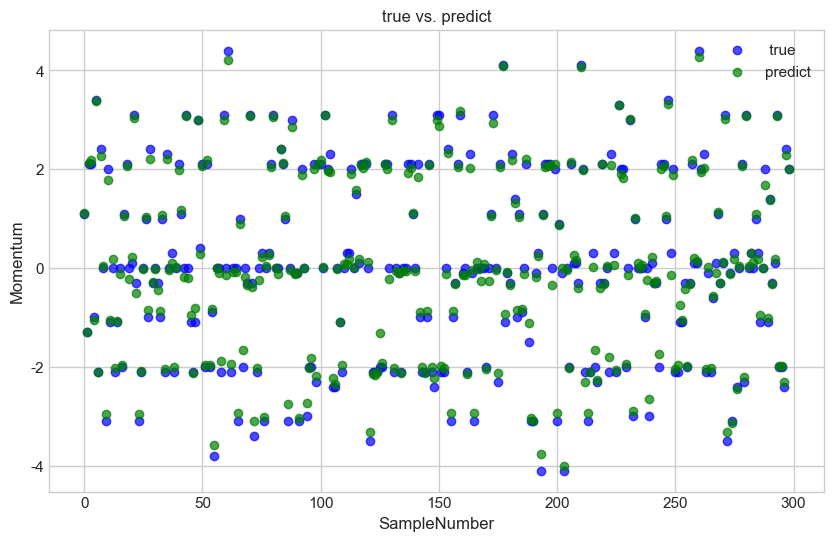

In [166]:
print("\nxgboost回归:")
# 构建xgboost回归模型
xgb_model = xgb.XGBRegressor(n_estimators=31,max_depth=6)
xgb_model.fit(X,Y)
y_pred = xgb_model.predict(X)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(X),y_pred)))
print("平均绝对误差:",mean_absolute_error(Y, y_pred))
print("r2_score",r2_score(Y,y_pred))

plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = xgb_model.predict(tr_x)
plt.scatter(list(range(X.shape[0])), Y, color='blue', label=' true', alpha=0.7)
plt.scatter(list(range(X.shape[0])), y_pred, color='green', label='predict', alpha=0.7)

# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('Momentum')
plt.legend()
# 显示图形
plt.show()




In [167]:
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)


# 计算SHAP值
shap_values = explainer(X)

In [168]:
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

In [169]:
# 输出每个特征的SHAP值（绝对值）
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)


In [170]:
tt=pd.DataFrame(features,columns=['features'])
tt['shap_values']=abs_mean_shap_values

In [171]:
tt1=pd.read_csv('tt.csv')
tt1

features            classify
0           p1_score_0            p1_score
1           p1_score_1            p1_score
2          p1_score_15            p1_score
3           p1_score_2            p1_score
4           p1_score_3            p1_score
..                 ...                 ...
64  p2_break_pt_missed  p2_break_pt_missed
65     p1_distance_run     p1_distance_run
66     p2_distance_run     p2_distance_run
67         rally_count         rally_count
68           speed_mph           speed_mph

[69 rows x 2 columns]

In [172]:
tt['classify']=tt1['classify']

In [173]:
tt

features  shap_values            classify
0           p1_score_0     0.040015            p1_score
1           p1_score_1     0.000000            p1_score
2          p1_score_15     0.040240            p1_score
3           p1_score_2     0.000281            p1_score
4           p1_score_3     0.000000            p1_score
..                 ...          ...                 ...
64  p2_break_pt_missed     0.000000  p2_break_pt_missed
65     p1_distance_run     0.222705     p1_distance_run
66     p2_distance_run     0.240069     p2_distance_run
67         rally_count     0.024922         rally_count
68           speed_mph     0.175039           speed_mph

[69 rows x 3 columns]

In [174]:
a=tt.groupby('classify').sum()
a

features  \
classify                                                                
game_no                                                       game_no   
game_victor                                               game_victor   
p1_ace                                                         p1_ace   
p1_break_pt                                               p1_break_pt   
p1_break_pt_missed                                 p1_break_pt_missed   
p1_break_pt_won                                       p1_break_pt_won   
p1_distance_run                                       p1_distance_run   
p1_double_fault                                       p1_double_fault   
p1_games                                                     p1_games   
p1_net_pt                                                   p1_net_pt   
p1_net_pt_won                                           p1_net_pt_won   
p1_points_won                                           p1_points_won   
p1_score            p1_score_0p1_score_1p1_score_15p1_score_2p1_sc...   
p1_sets                                                       p1_sets   
p1_unf_err                                                 p1_unf_err   
p1_winner                                                   p1_winner   
p2_ace                                                         p2_ace   
p2_break_pt                                               p2_break_pt   
p2_break_pt_missed                                 p2_break_pt_missed   
p2_break_pt_won                                       p2_break_pt_won   
p2_distance_run                                       p2_distance_run   
p2_double_fault                                       p2_double_fault   
p2_games                                                     p2_games   
p2_net_pt                                                   p2_net_pt   
p2_net_pt_won                                           p2_net_pt_won   
p2_points_won                                           p2_points_won   
p2_score            p2_score_0p2_score_1p2_score_15p2_score_2p2_sc...   
p2_sets                                                       p2_sets   
p2_unf_err                                                 p2_unf_err   
p2_winner                                                   p2_winner   
point_no                                                     point_no   
point_victor                                             point_victor   
rally_count                                               rally_count   
serve_depth                           serve_depth_CTLserve_depth_NCTL   
serve_no                                                     serve_no   
serve_width         serve_width_Bserve_width_BCserve_width_BWserve...   
server                                                         server   
set_no                                                         set_no   
set_victor                                                 set_victor   
speed_mph                                                   speed_mph   
winner_shot_type    winner_shot_type_0winner_shot_type_Bwinner_sho...   

                    shap_values  
classify                         
game_no                0.077385  
game_victor            0.108465  
p1_ace                 0.002238  
p1_break_pt            0.007143  
p1_break_pt_missed     0.009149  
p1_break_pt_won        0.000000  
p1_distance_run        0.222705  
p1_double_fault        0.008103  
p1_games               0.086445  
p1_net_pt              0.031100  
p1_net_pt_won          0.001183  
p1_points_won          0.000000  
p1_score               0.142190  
p1_sets                0.000000  
p1_unf_err             0.013956  
p1_winner              0.131350  
p2_ace                 0.019851  
p2_break_pt            0.002191  
p2_break_pt_missed     0.000000  
p2_break_pt_won        0.000000  
p2_distance_run        0.240069  
p2_double_fault        0.001287  
p2_games               0.090629  
p2_net_pt              0.010529  
p2_net_pt_won          0.000595  
p2_

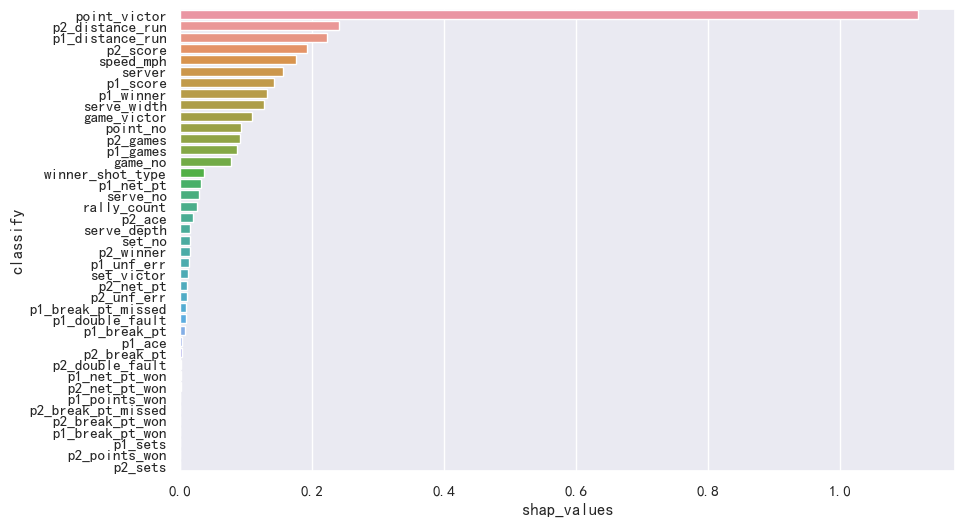

In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.rcParams['font.sans-serif'] = ['SimHei']  
# Matplotlib中设置字体-黑体，解决Matplotlib中文乱码问题
plt.rcParams['axes.unicode_minus'] = False    
# 解决Matplotlib坐标轴负号'-'显示为方块的问题
sns.set(font='SimHei')                        
# Seaborn中设置字体-黑体，解决Seaborn中文乱码问题
a_sorted = a.sort_values(by='shap_values', ascending=False)

# 设置图表大小，例如设置为宽10英寸，高6英寸
plt.figure(figsize=(10, 6))
# 使用Seaborn绘制柱状图
sns.barplot(x='shap_values', y='classify', data=a_sorted.reset_index(), orient='h')
plt.savefig('classify')
# 显示图形
plt.show()

In [176]:

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)

shap.initjs() #初始化JS
shap_values = explainer.shap_values(X) #计算每个样本的每个特征的SHAP值

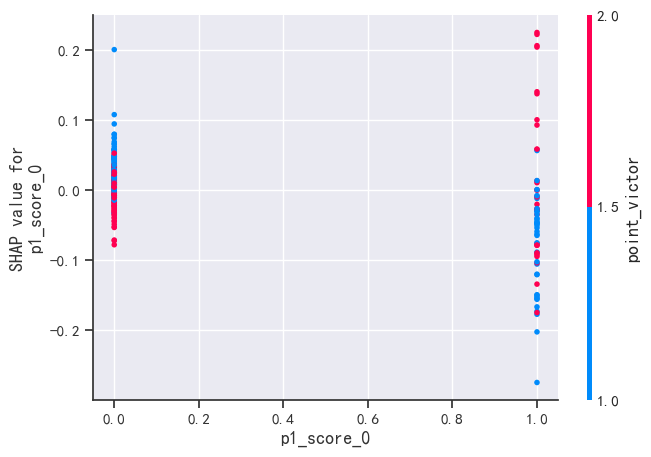

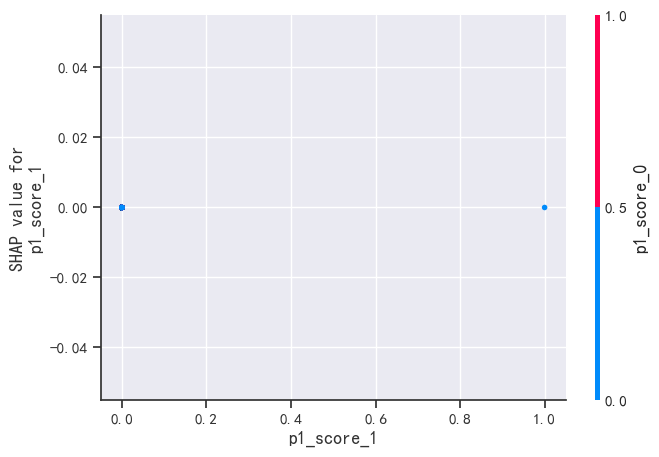

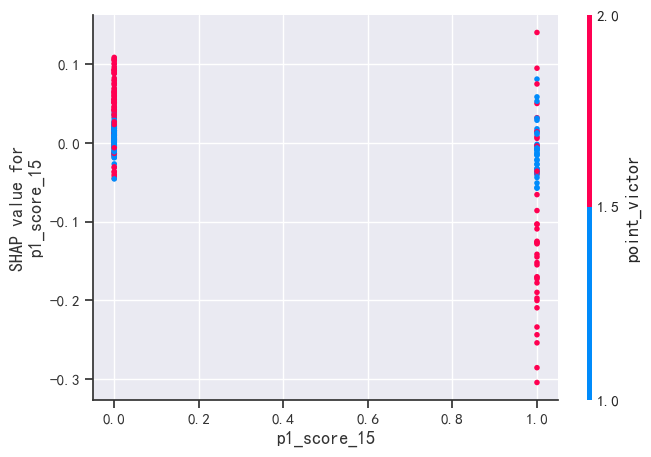

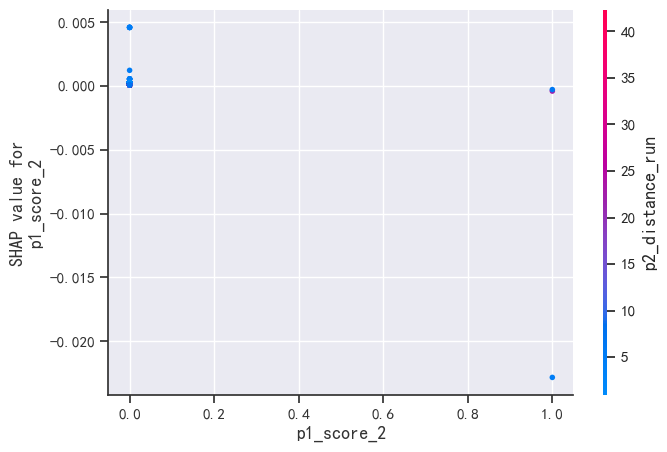

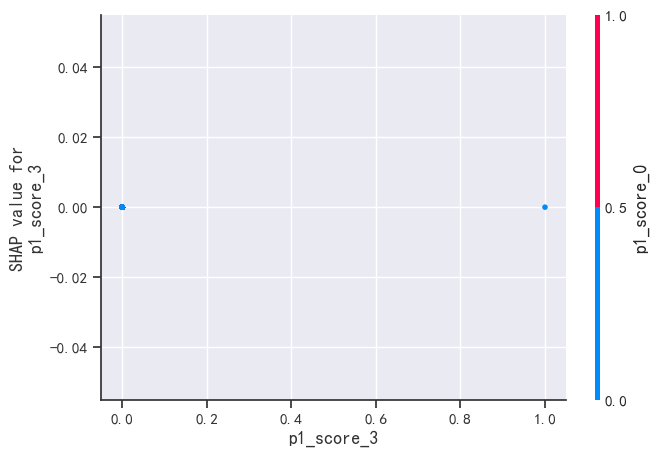

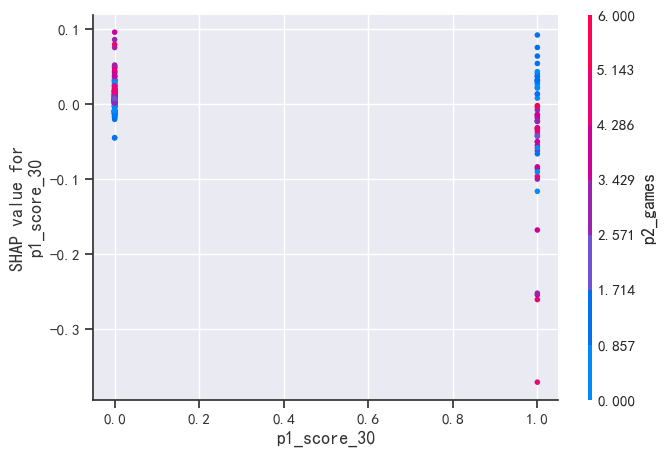

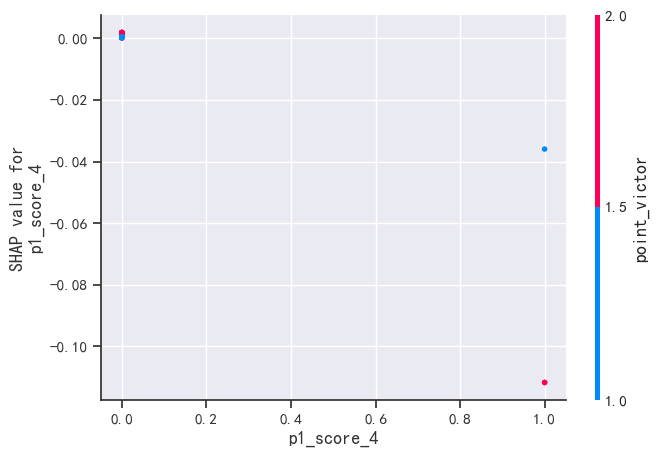

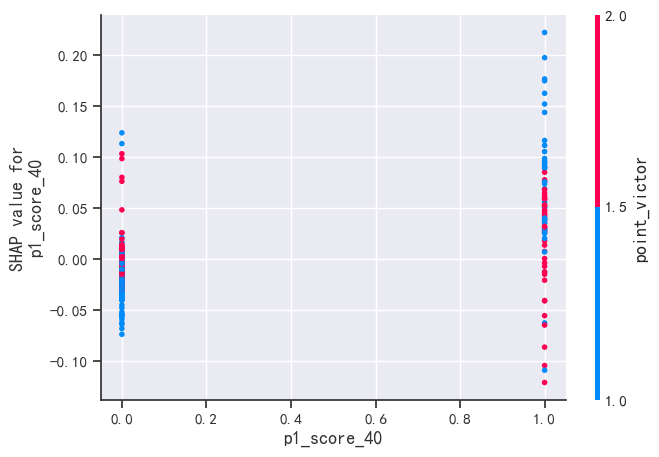

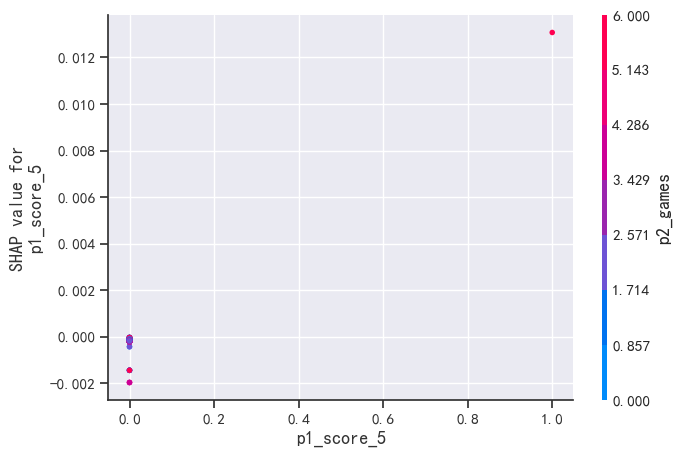

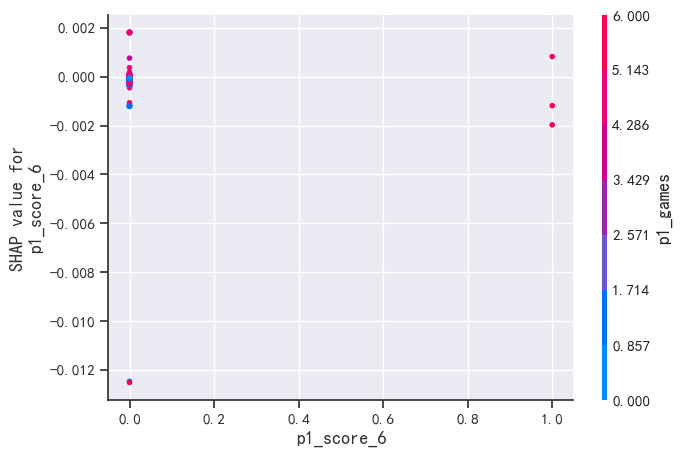

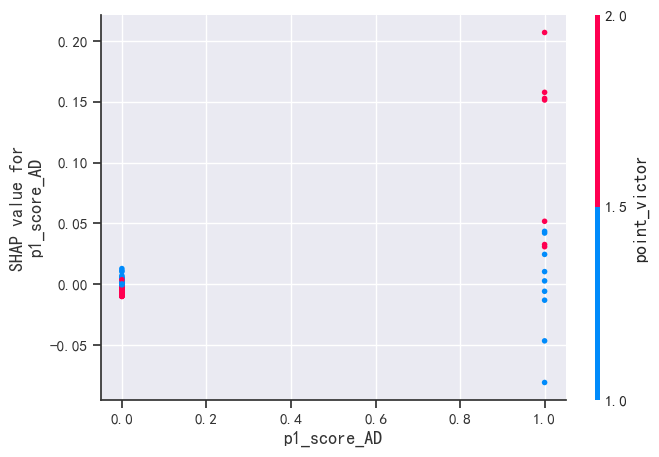

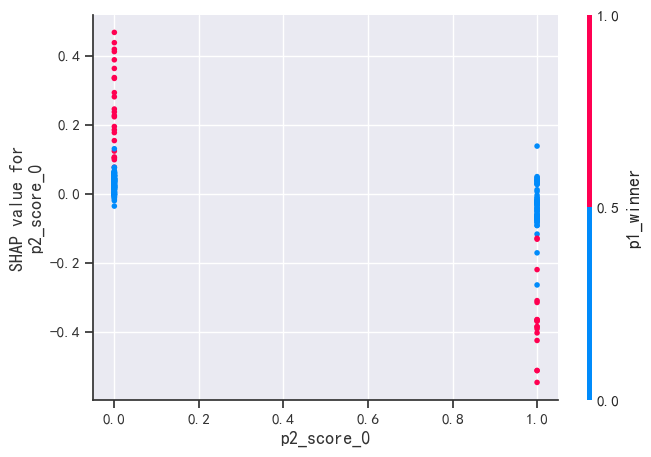

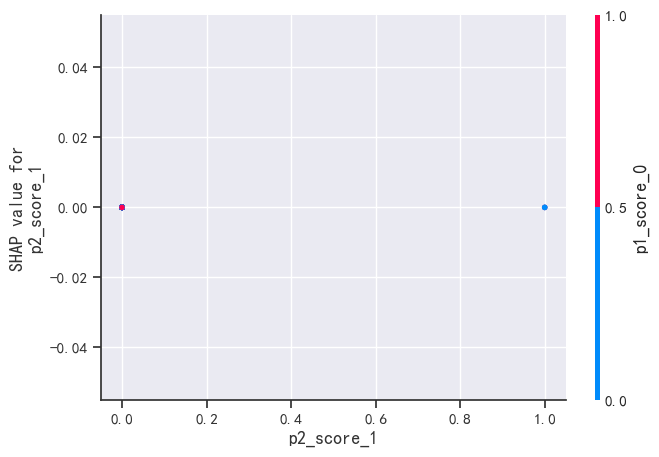

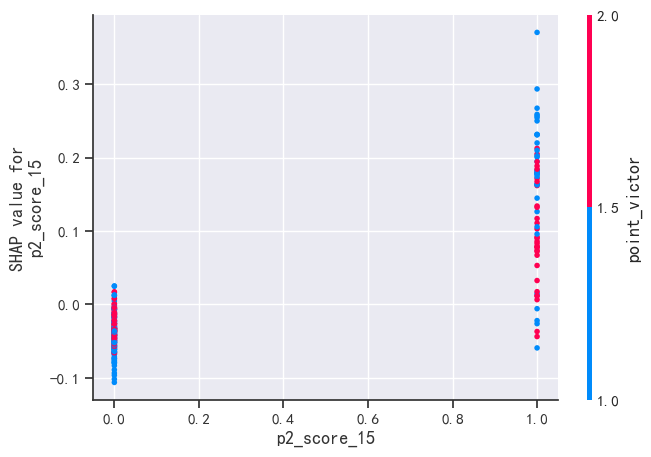

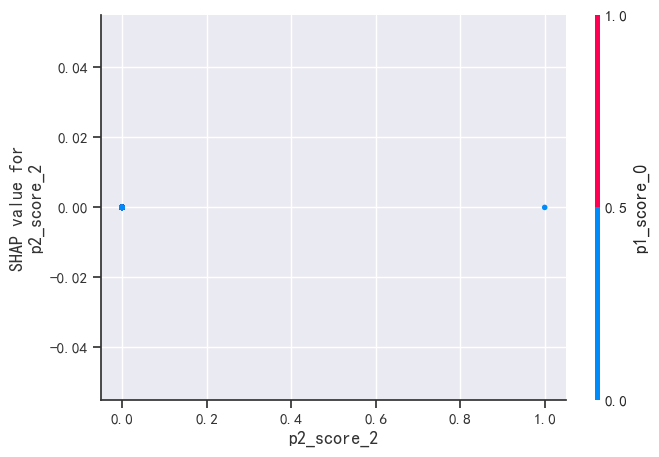

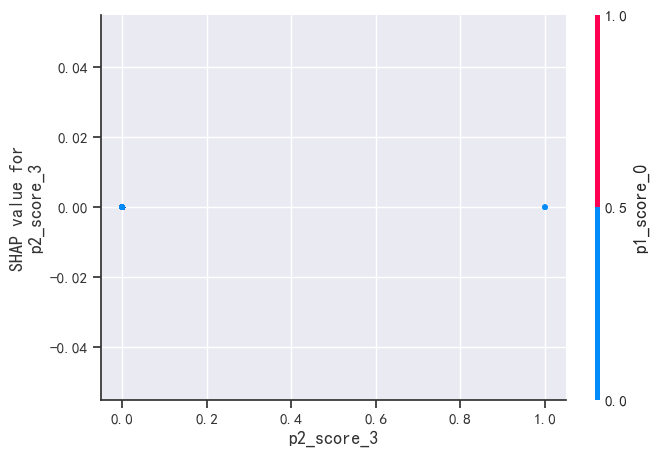

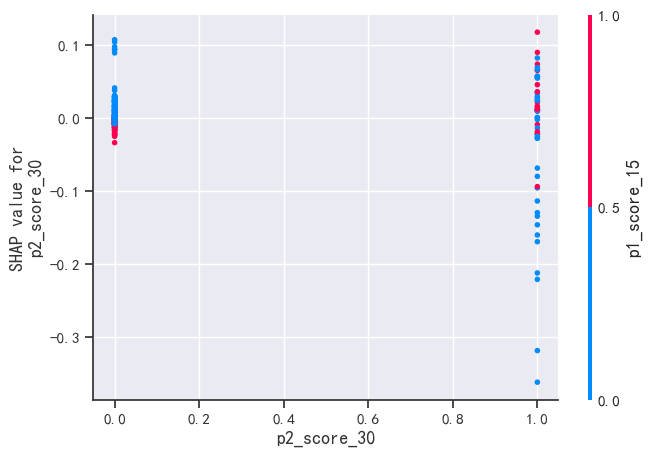

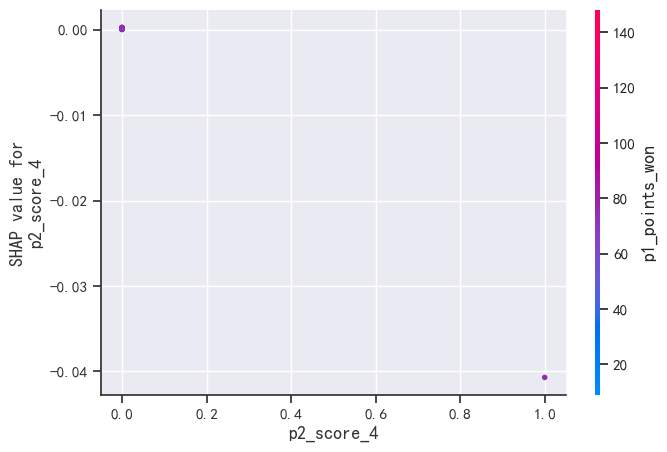

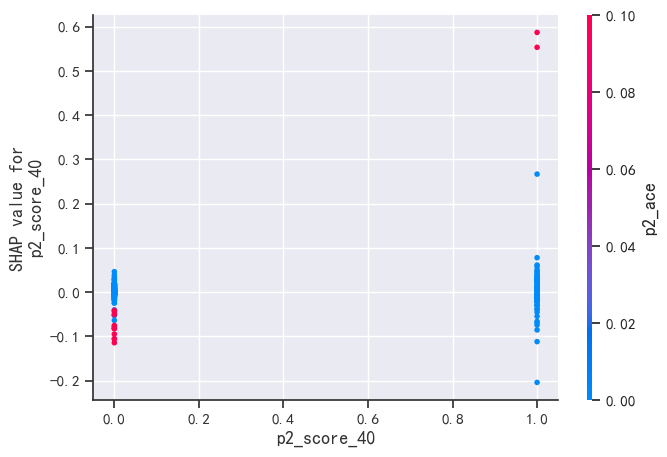

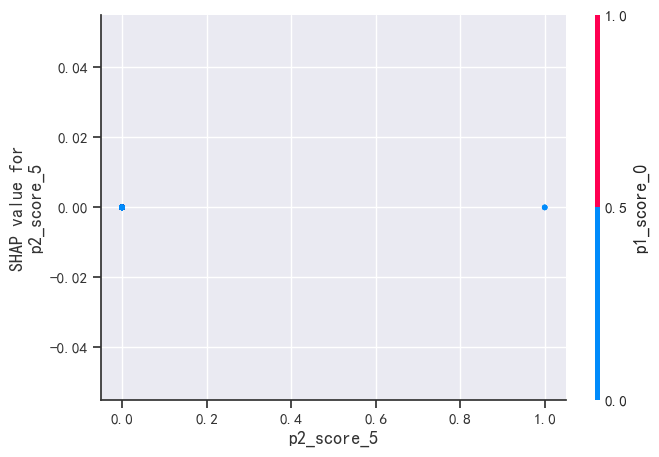

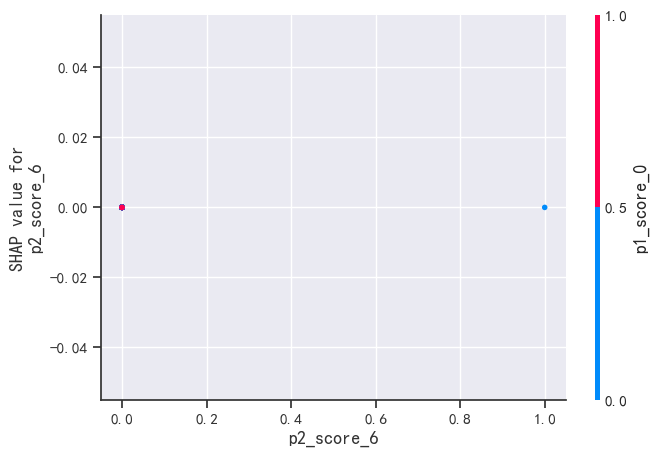

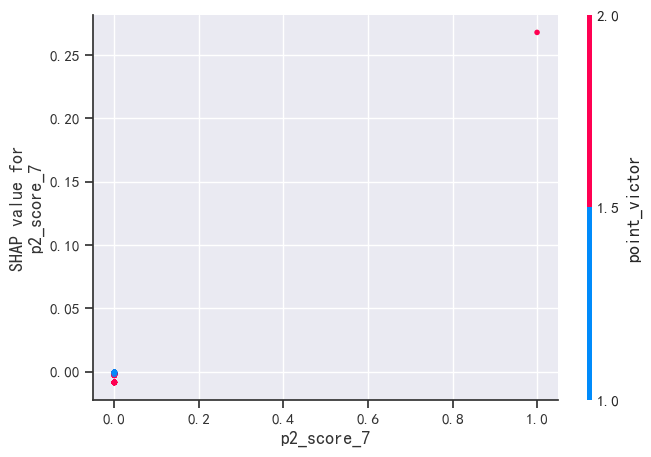

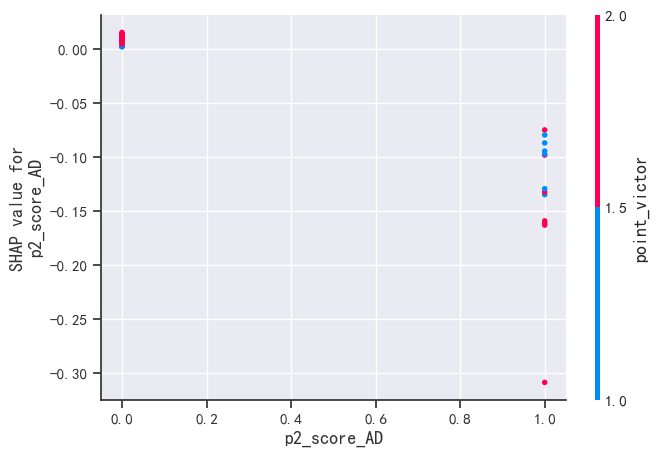

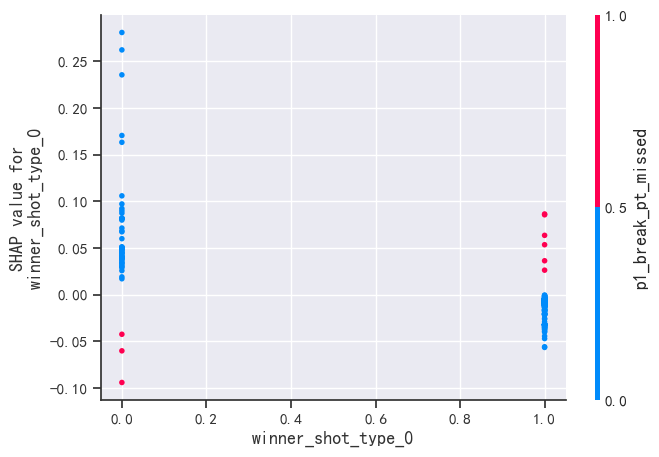

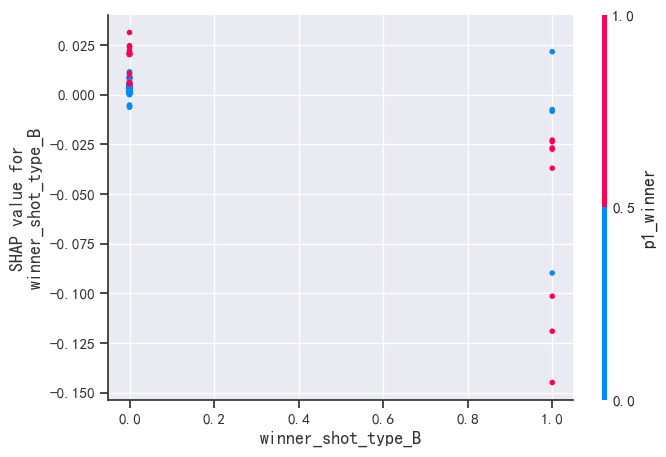

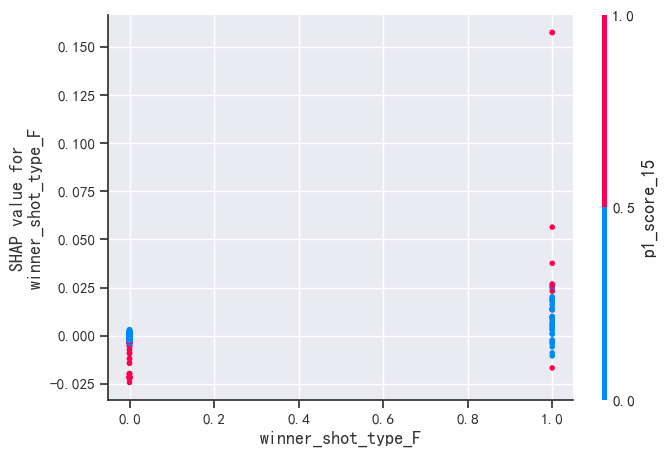

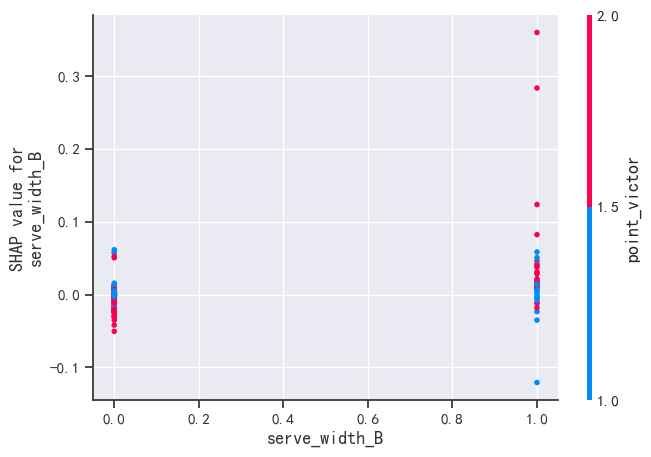

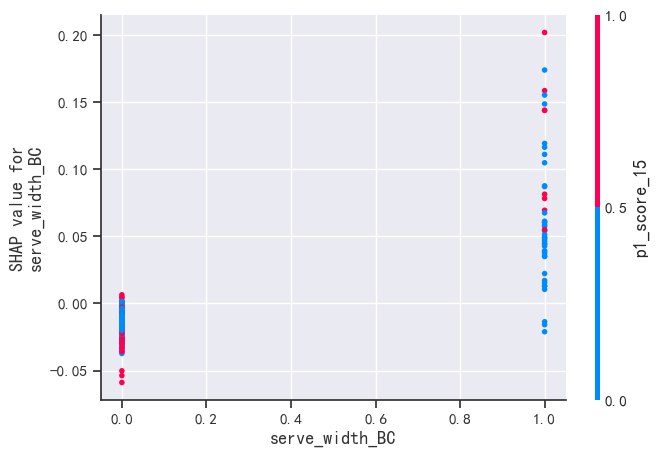

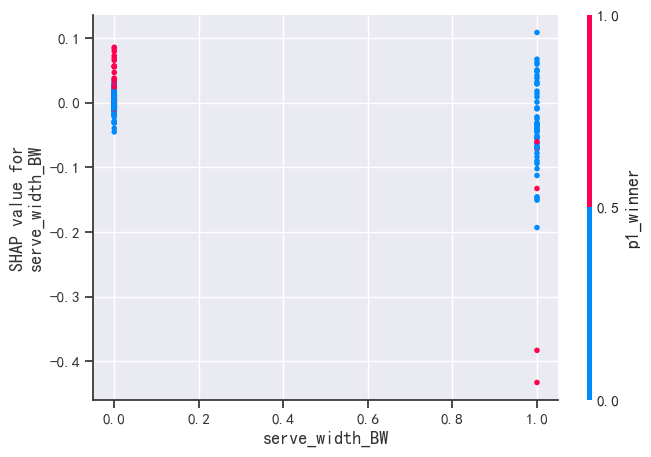

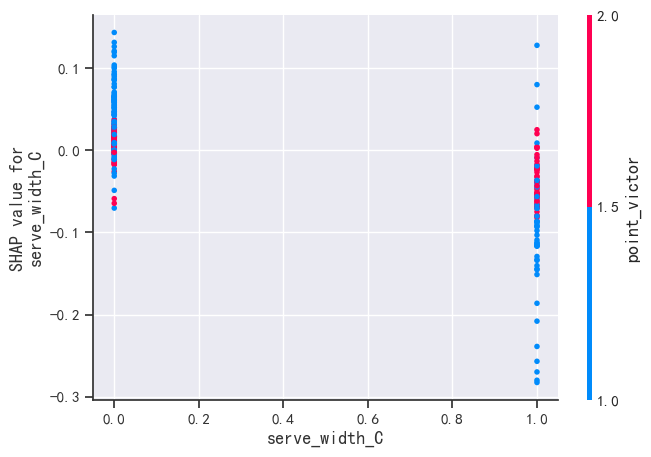

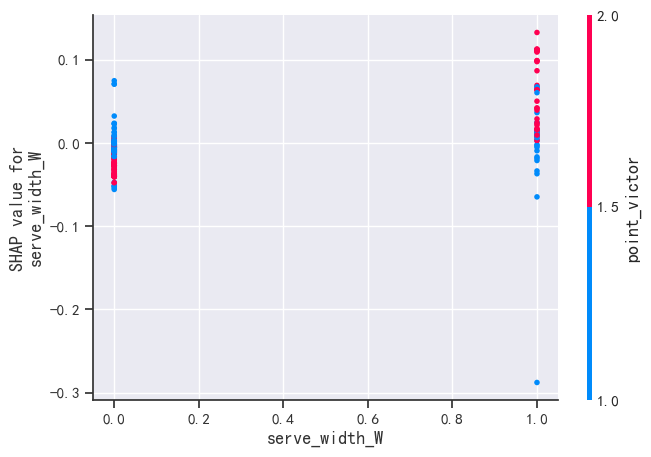

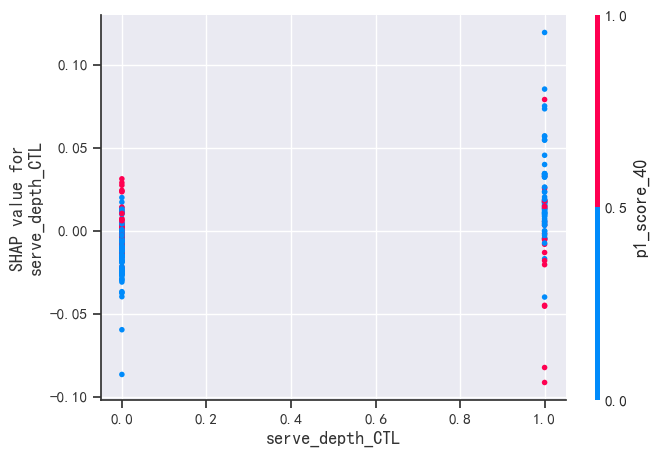

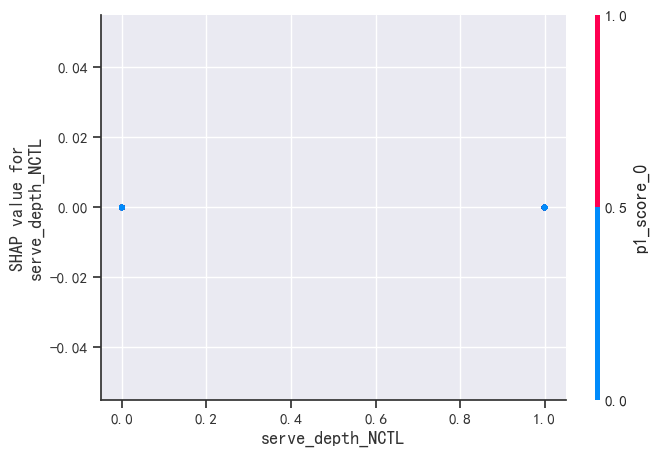

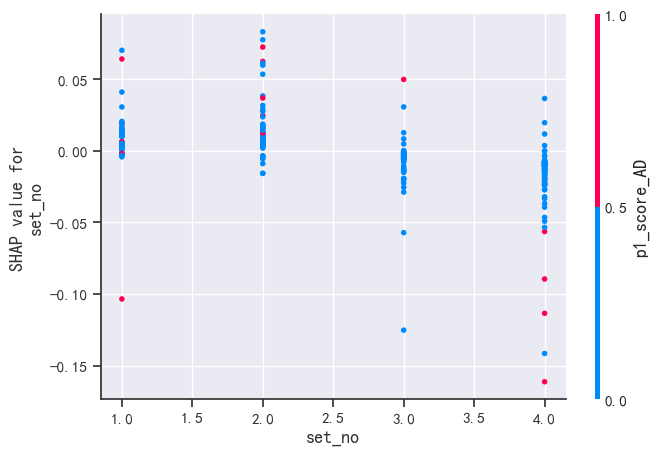

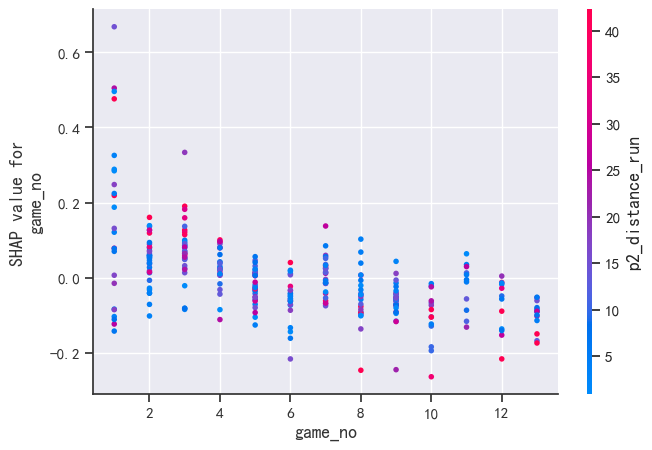

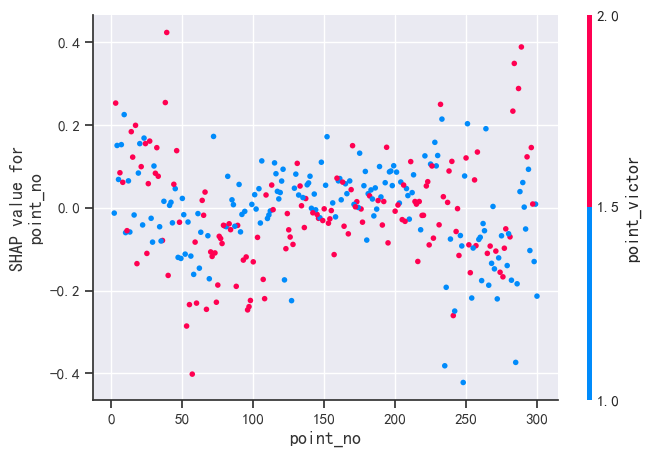

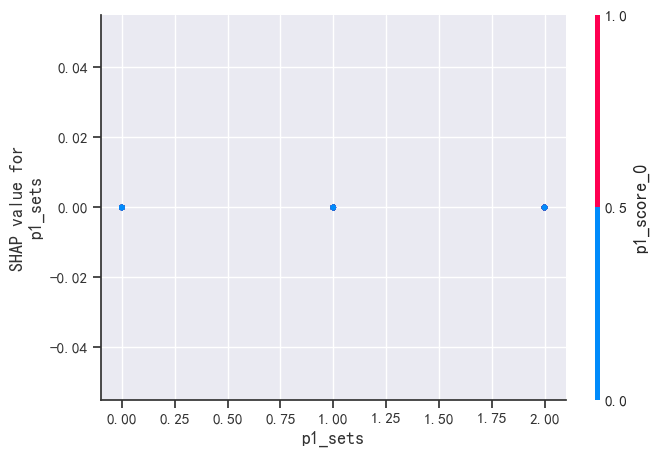

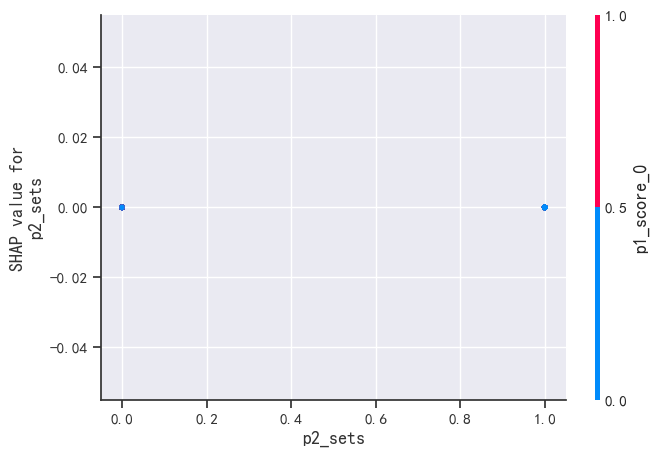

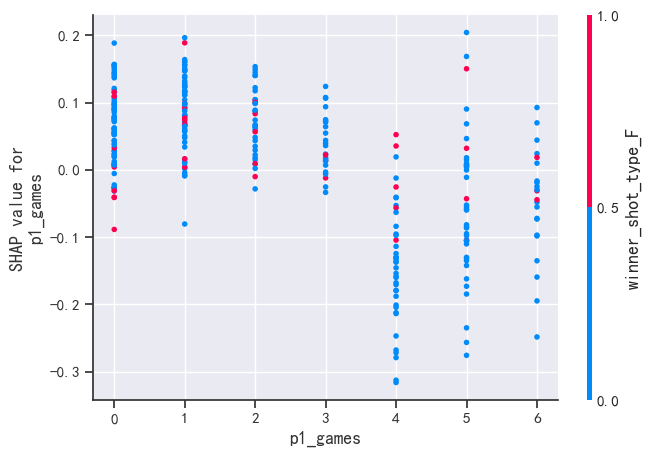

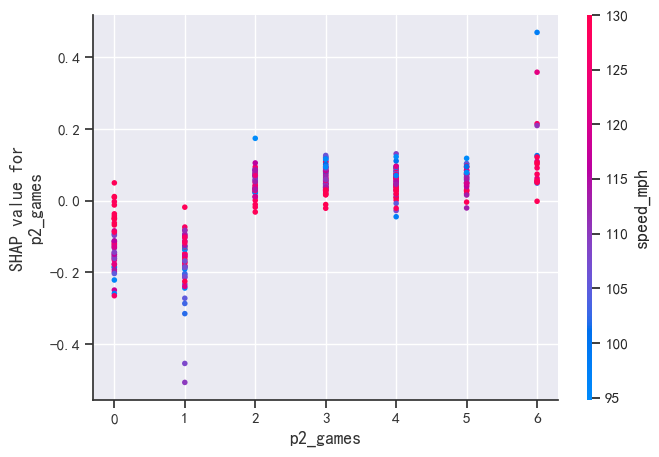

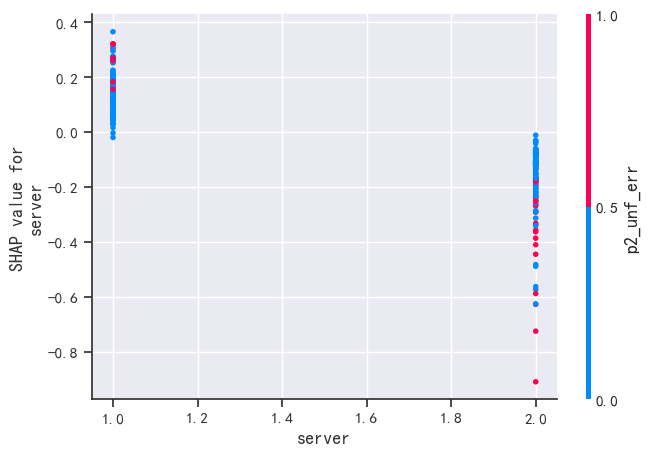

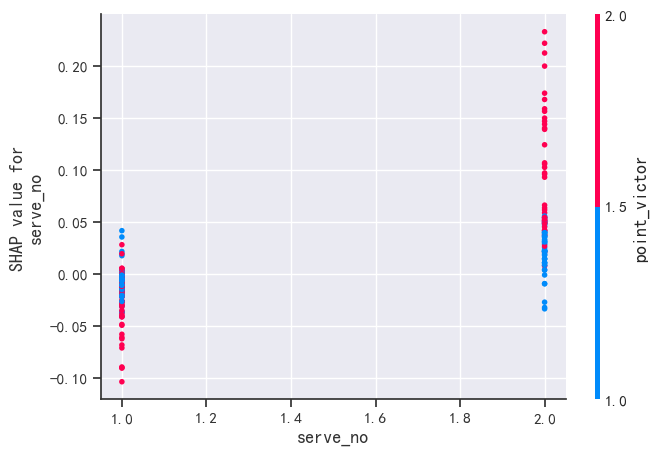

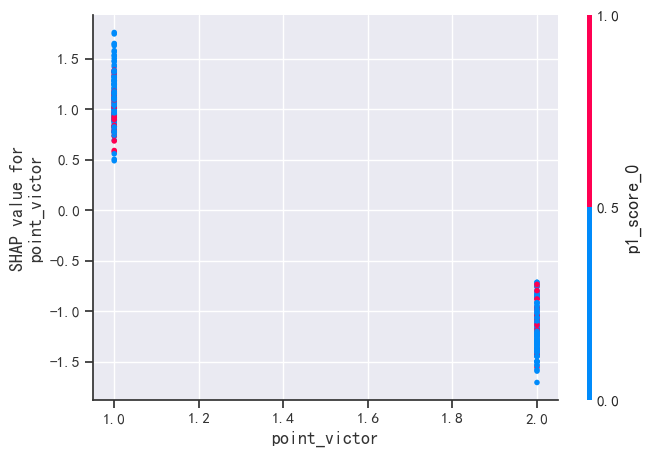

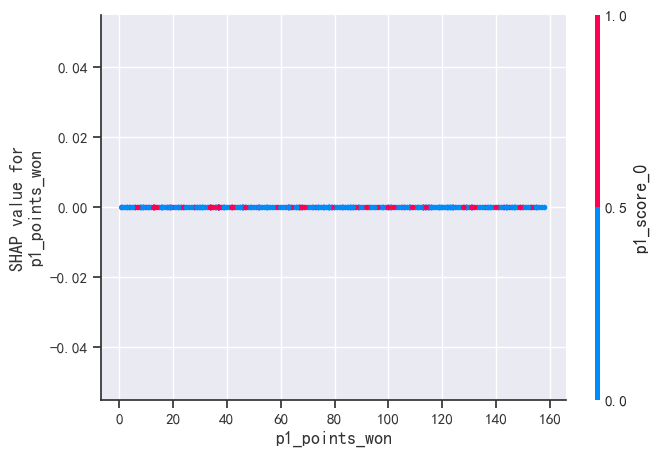

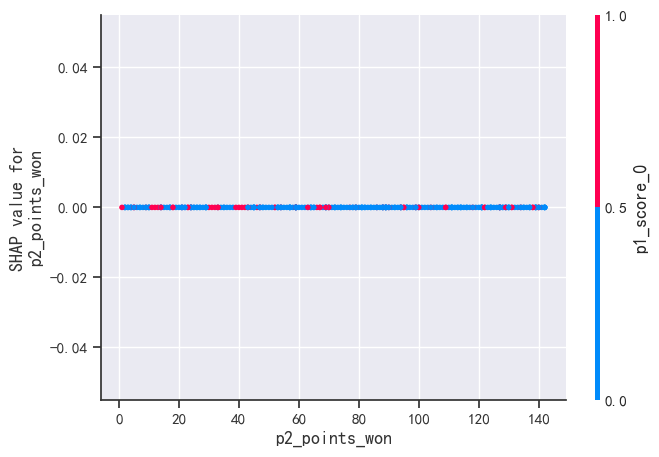

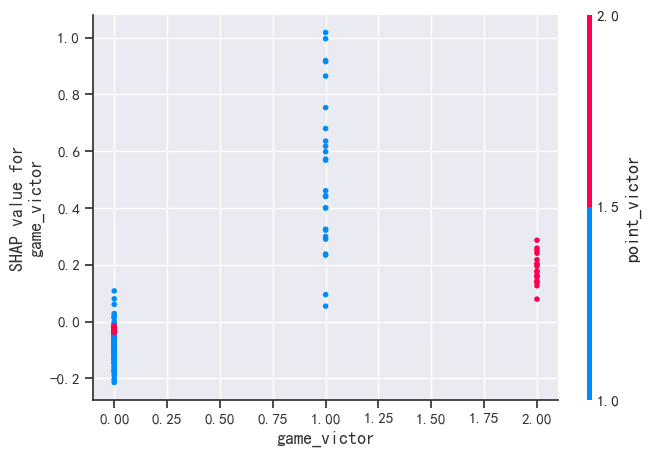

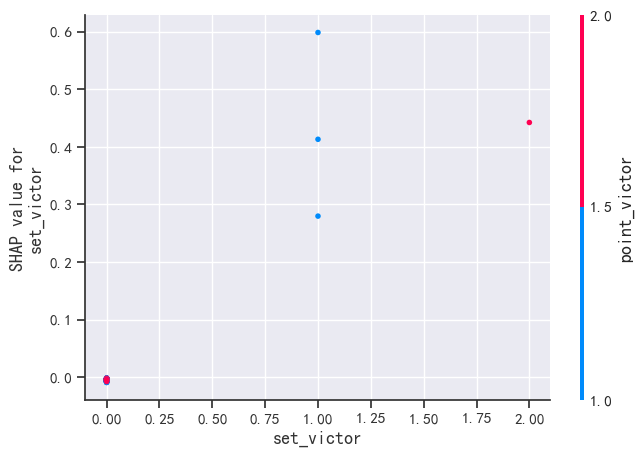

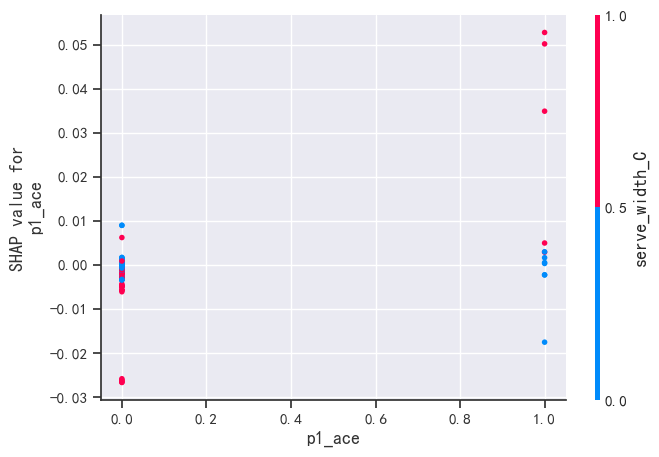

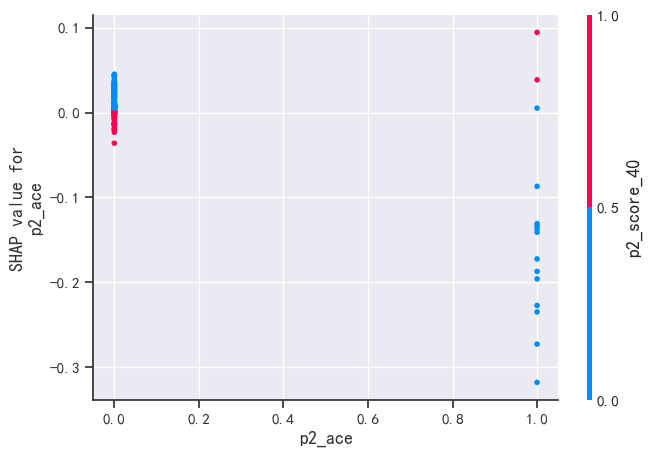

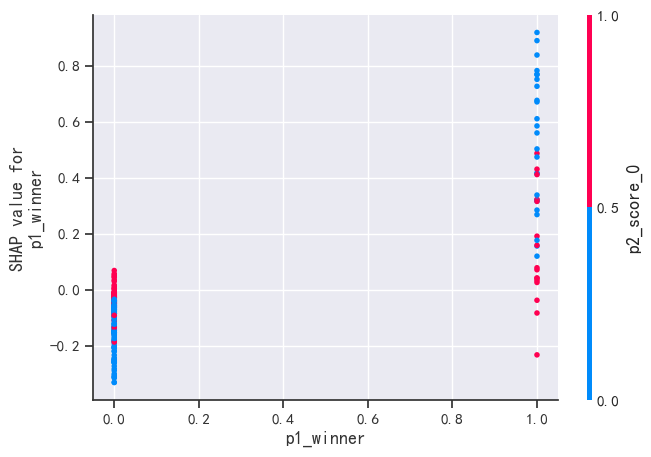

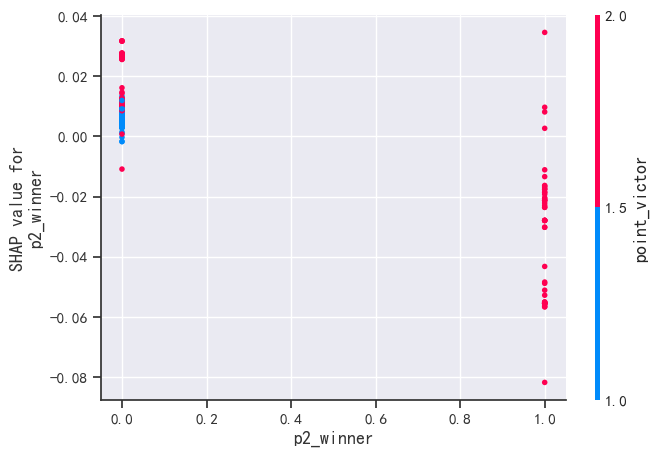

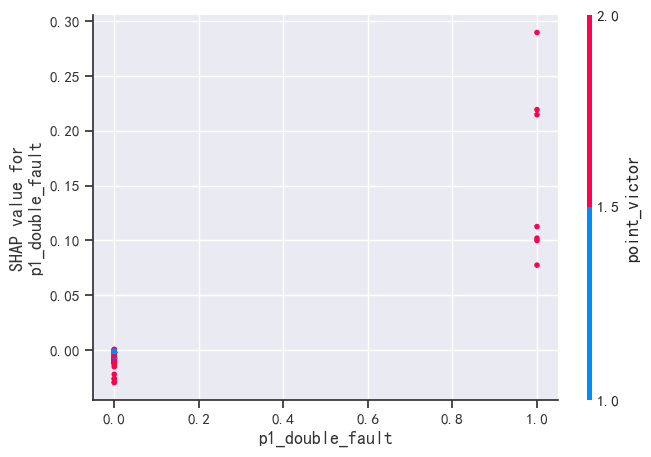

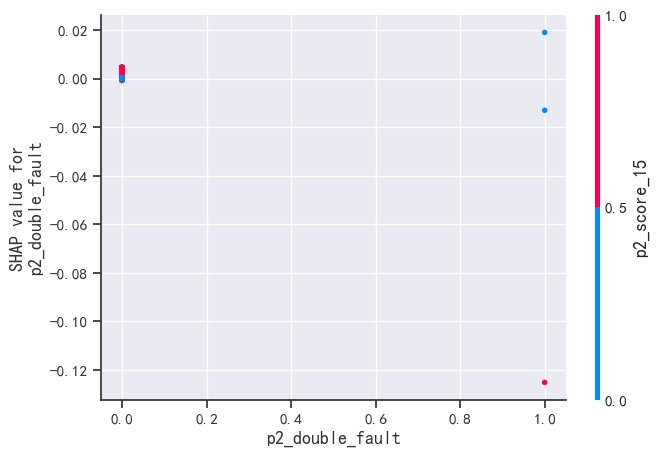

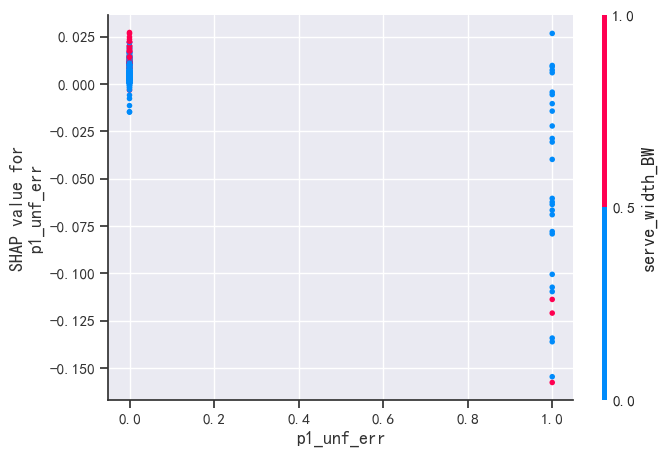

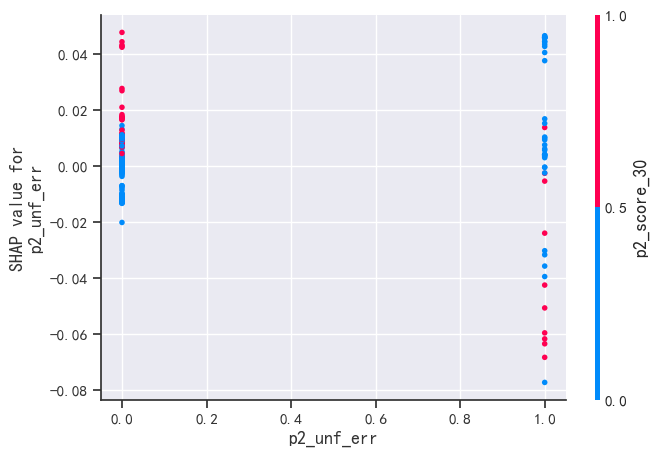

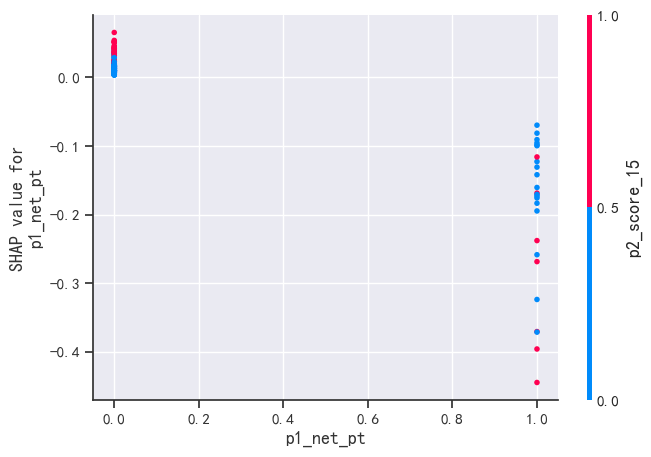

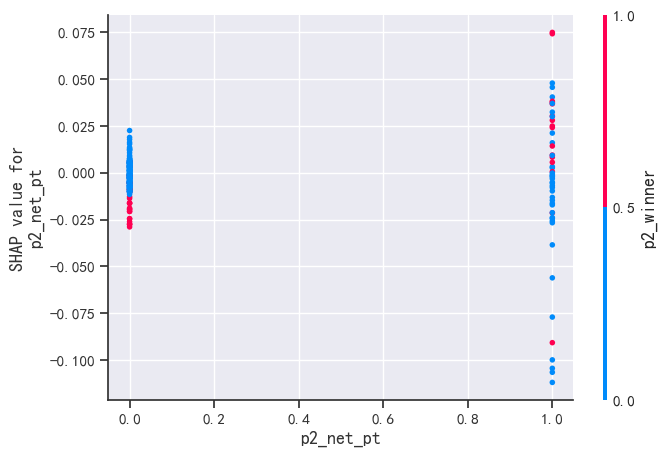

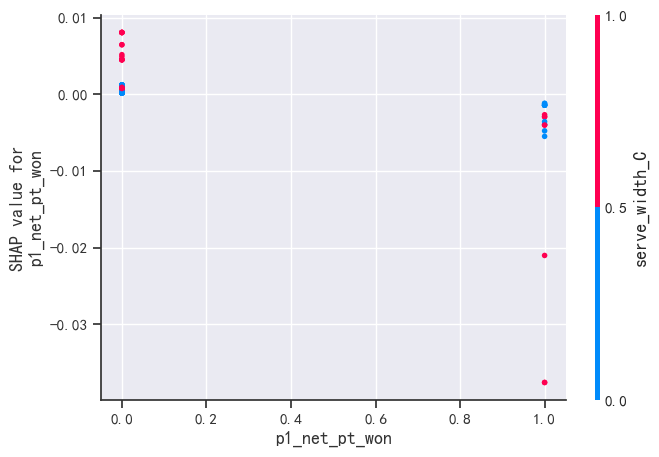

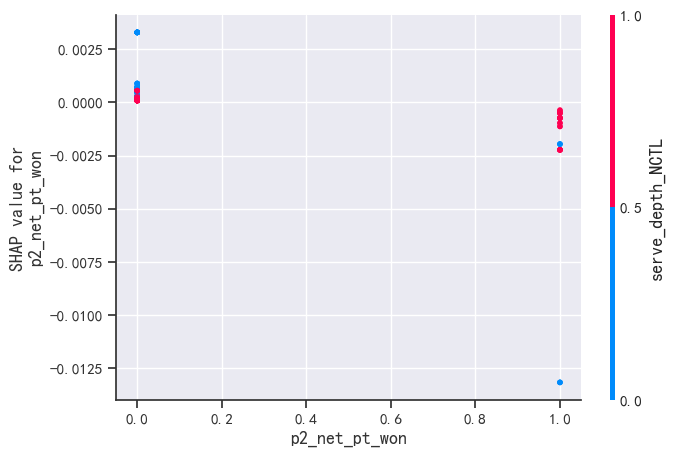

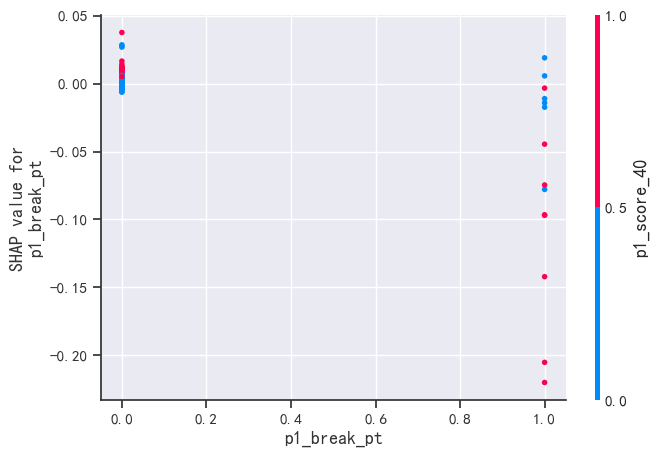

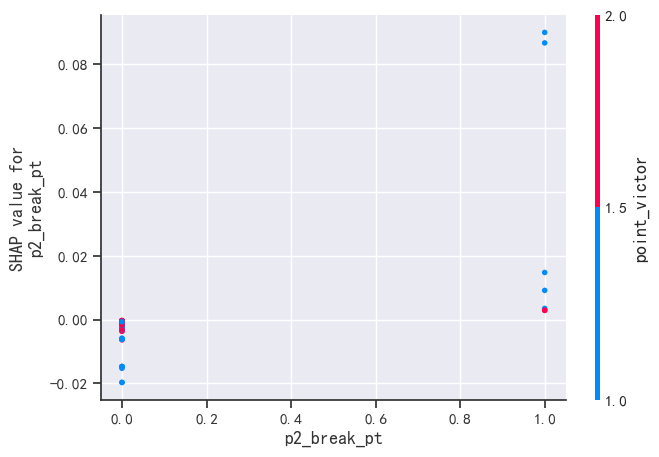

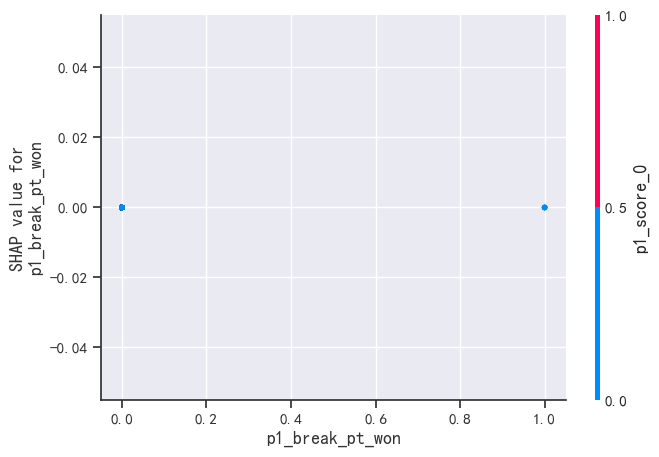

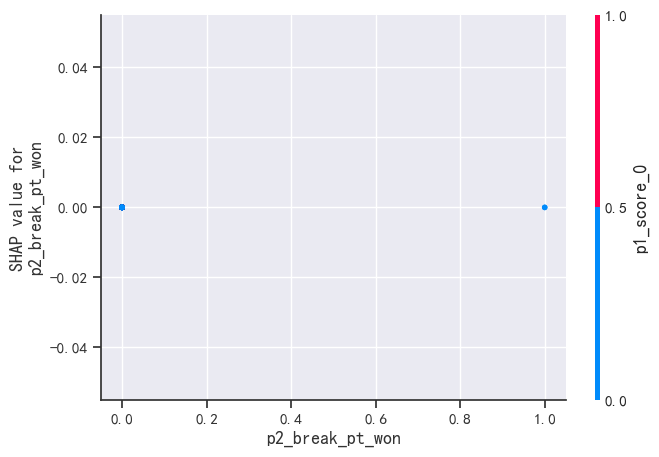

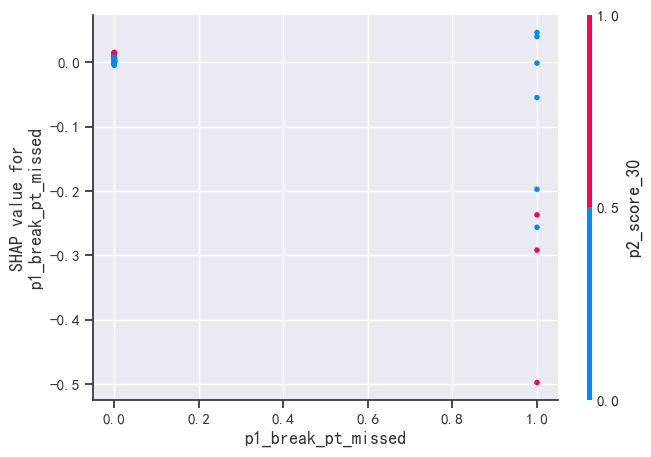

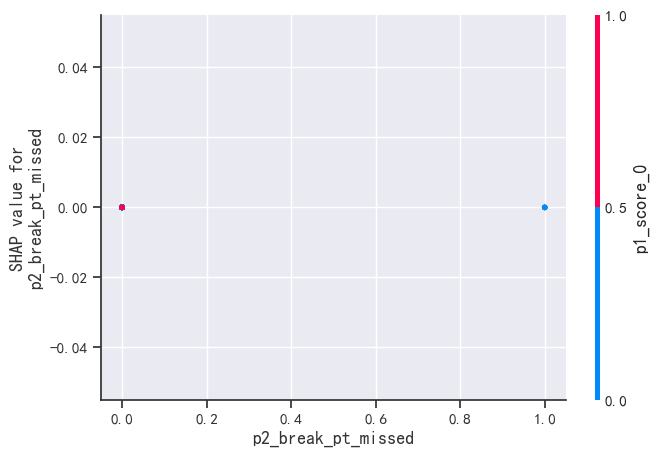

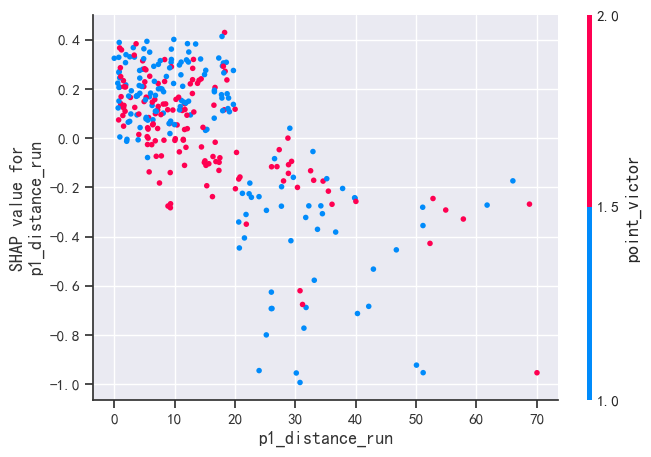

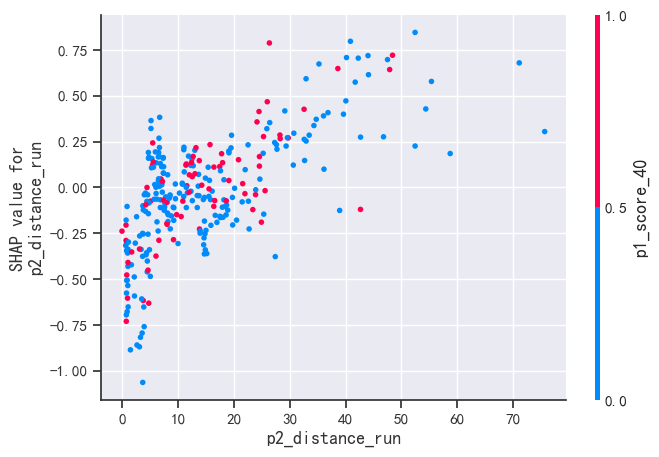

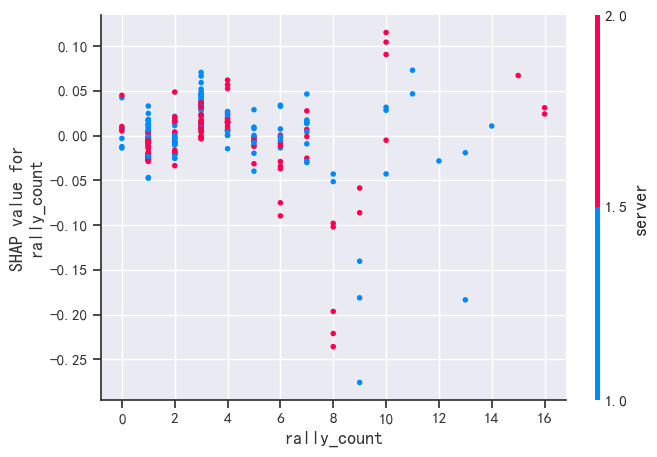

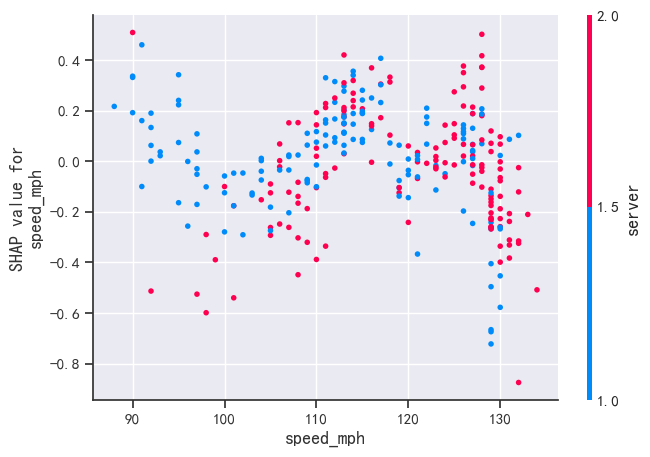

In [177]:
for i in X.columns:
    shap.dependence_plot(i, shap_values, X)

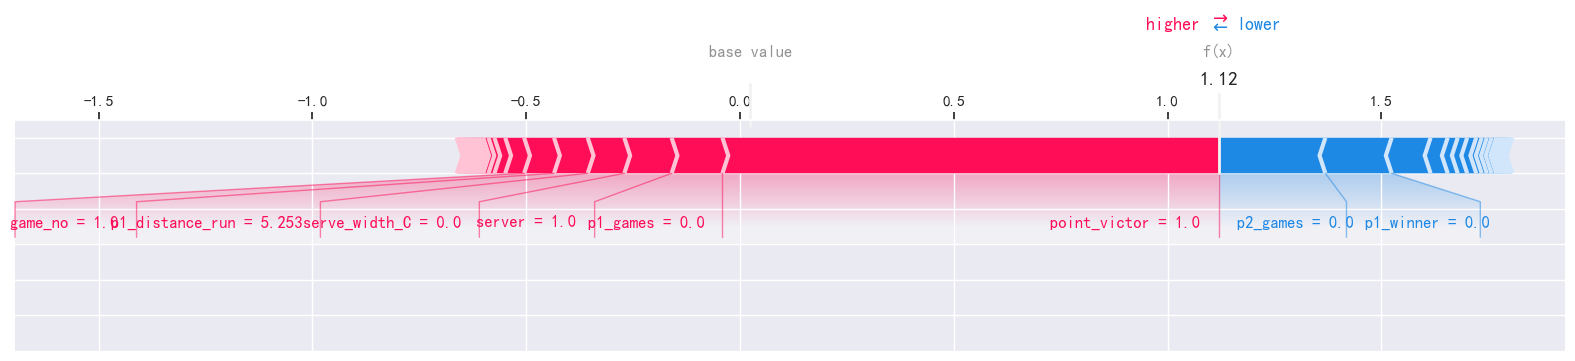

In [178]:
i=0
shap.force_plot(explainer.expected_value, shap_values[i,:], data[X.columns].iloc[i,:],matplotlib=True) #3860为样本在数据集中的索引

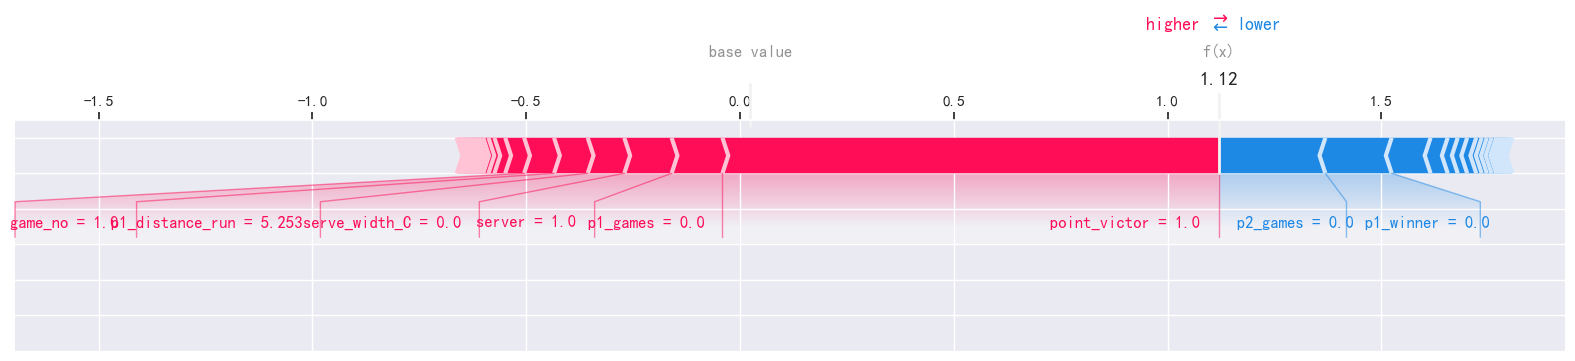

In [179]:
i=0
shap.force_plot(explainer.expected_value, shap_values[i,:], data[X.columns].iloc[i,:],matplotlib=True) #3860为样本在数据集中的索引

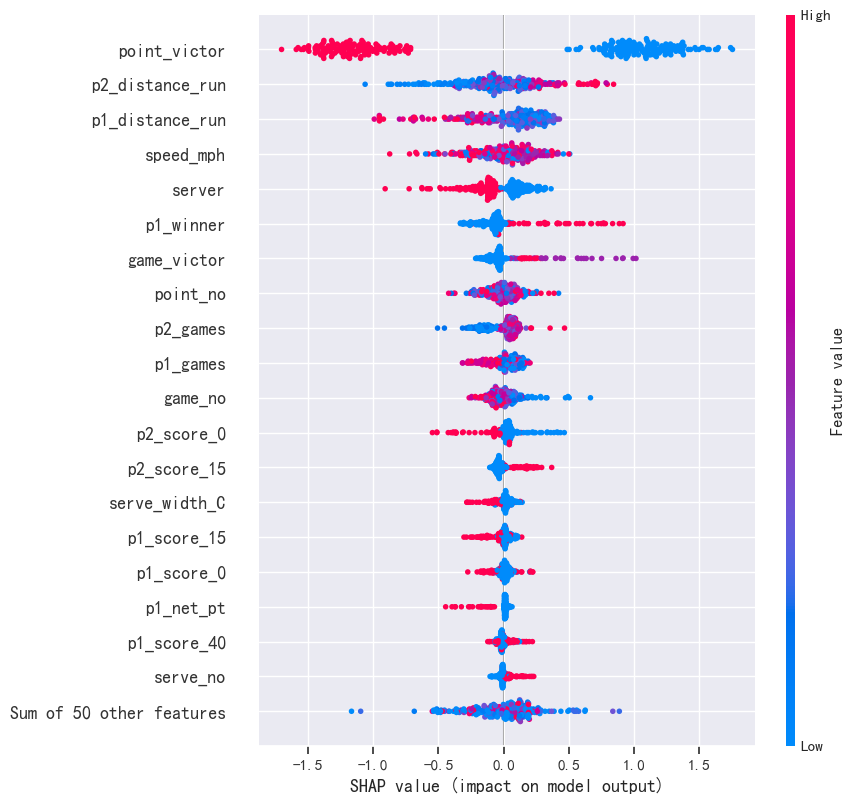

In [180]:
shap.plots.beeswarm(explainer(X),max_display=20)

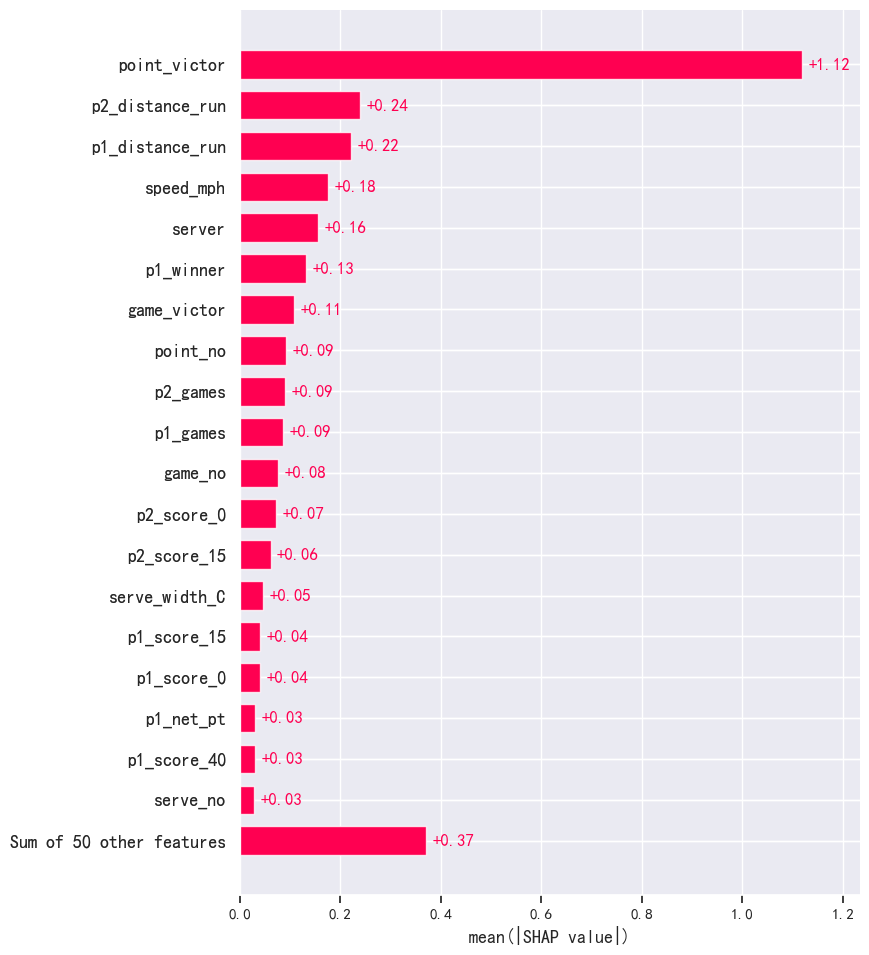

In [181]:
shap.plots.bar(explainer(X),max_display=20)

In [182]:
shap.force_plot(explainer.expected_value, shap_values, X, link="logit")

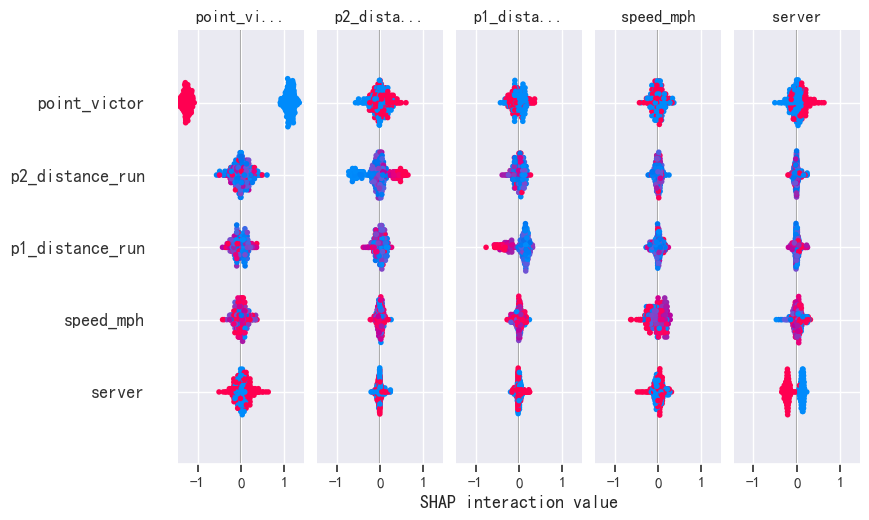

In [183]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X,max_display=5)

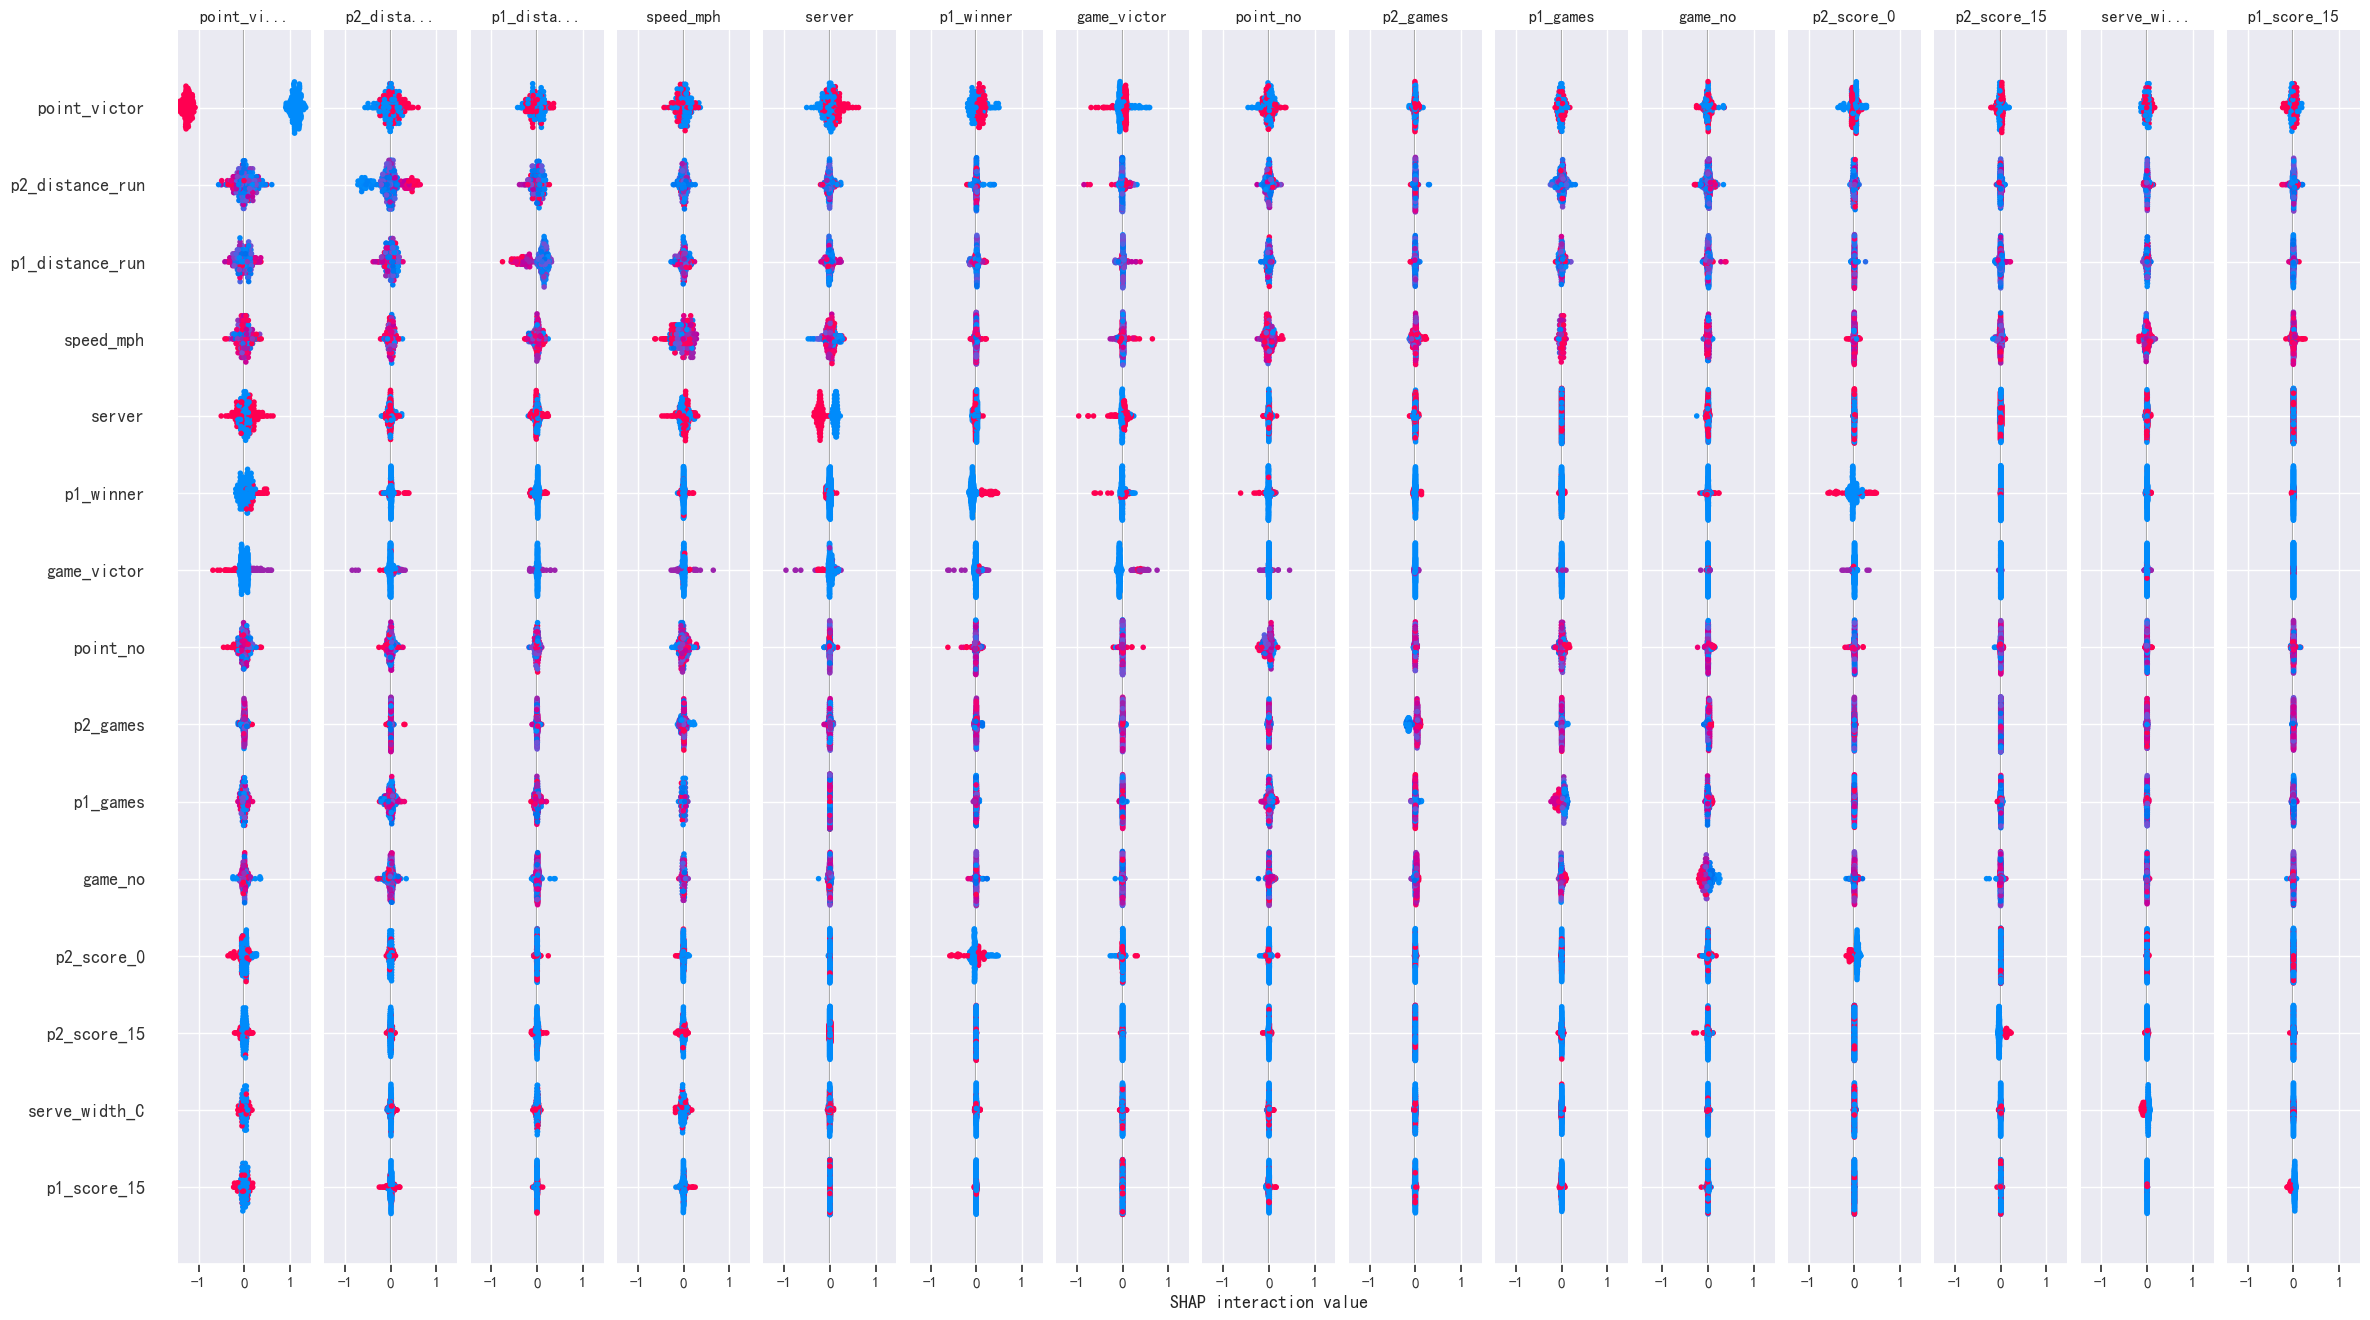

In [184]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X,max_display=15)